In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import linear_regression
from linear_regression import LinearRegression
import algorithms
import gurobipy as gp
from gurobipy import GRB
import scipy.linalg
import itertools

In [2]:
# force reimport
import importlib
importlib.reload(linear_regression)

<module 'linear_regression' from '/Users/JennyH/Desktop/if-image-text/image-text/gradientBasedDataDroppingFailureModes/linear_regression.py'>

### With very small variances in the red-cross points (<1e-9) (i.e. near-singular covariance matrix) can we produce a case where Greedy Newton work and Greedy AMIP fail?

# Greedy Failures [Adversarial]

In [3]:
np.random.seed(0)

# I. Generate the data.
num_dimensions = 2
total_observations = 1000
eps = 1e-9
# 4/08: scaling argument works (noise in large population: 1e-5, mean in smaller population = 10, slope -5, intercept -10:
# greedy amip fails, greedy newton works)

# 4/08: scaling argument interesting result (noise in large population: 1e-4, mean in smaller population = 10, slope -5, intercept -10:
# greedy amip fails, greedy newton also doesn't work?)

# Mixing proportions
num_observations_pop_1 = 10 # A (small fraction)
num_observations_pop_2 = total_observations - num_observations_pop_1 # B

mean_pop_1 = np.array([-1, 0]) # 4/08: adjust the location of the outlier group.
mean_pop_2 = np.array([0, 0])

eps_outlier_clump = 0.01 # 0.01, vs. 1e-7. change the variance here to make the small population clustered together.
vars_pop_1 = np.array([[eps_outlier_clump, 0], [0, 1]])
vars_pop_2 = np.array([[eps, 0], [0, 1]]) # when pop B is all zero, the line fits perfectly.



In [4]:
# generate the X values for two populations.
x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)
x = np.append(x1, x2, axis=0)
x

array([[-9.59984279e-01,  1.76405235e+00],
       [-7.75910680e-01,  9.78737984e-01],
       [-1.09772779e+00,  1.86755799e+00],
       ...,
       [ 3.09115179e-06,  1.97828168e-01],
       [ 5.01011814e-06,  1.40152342e+00],
       [-4.14565232e-05, -1.14190142e+00]])

In [5]:
x1_0 = [pt[0] for pt in x1]
x1_1 = [pt[1] for pt in x1]
x2_0 = [pt[0] for pt in x2]
x2_1 = [pt[1] for pt in x2]

In [6]:
# add intercept term. NDArray -> df -> NDArray
df = pd.DataFrame(x)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr
x

x1 = x[:10]
x2 = x[10:]

In [7]:
orig_x = x # (4/01: save this for after running the greedy loop.)

In [8]:
# Generating the Y values.
slope = -5 # (-1, -1, 5)
intercept = -10 # (-10, 10, 20)
y1 = [slope*element + intercept for element in x1_0] # y = beta * x1 + 0 * x2 + intercept.
y2 = np.random.randn(1, num_observations_pop_2) # No(0, 1)
y2 = y2[0] # format results of np.randn 
y = np.concatenate([y1, y2], axis=0)

In [9]:
orig_y = y # (4/01: save this for after running the greedy code.)

In [10]:
# II. Fit the regression.
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_a = LinearRegression(x=x1.T, y=y1)
modified_lr_a.fit()
print(
    f"Estimated beta1 pop A: {modified_lr_a.beta[1]}"
)

modified_lr = LinearRegression(x=x2.T, y=y2)
modified_lr.fit()
print(
    f"Estimated beta1 pop B: {modified_lr.beta[1]}"
)

Estimated beta1 with full dataset: 5.13372787270511
Estimated beta1 pop A: -4.999999999999995
Estimated beta1 pop B: -480.83508957276007


In [12]:
greedy_fails_df = linear_regression.compute_scores(x, y, lr)
greedy_fails_df

,x,y,residual,leverage,IF,1Exact,sorted_IF_indices,sorted_1Exact_indices,sorted_IF_scores,sorted_1Exact_scores
0,-0.959984,-5.200079,-0.207706,0.097485,-0.020714,-0.022951,1,1,-0.168030,-0.179375
1,-0.775911,-6.120447,-2.078504,0.063249,-0.168030,-0.179375,5,5,-0.115926,-0.125595
2,-1.097728,-4.511361,1.188867,0.127167,0.135930,0.155735,4,4,-0.023460,-0.025991
3,-1.015136,-4.924321,0.345539,0.108036,0.036772,0.041226,0,0,-0.020714,-0.022951
4,-0.958940,-5.205299,-0.231237,0.097385,-0.023460,-0.025991,7,7,-0.015209,-0.016864
...,...,...,...,...,...,...,...,...,...,...
995,-0.000023,-0.224092,-0.162821,0.003014,0.000387,0.000388,6,6,0.007004,0.007802
996,-0.000010,1.967730,2.028743,0.002934,-0.004773,-0.004788,3,3,0.036772,0.041226
997,0.000003,0.447683,0.500880,0.001066,-0.000629,-0.000629,8,8,0.042991,0.048280
998,0.000005,-0.662191,-0.600657,0.003189,0.001465,0.001470,9,9,0.120651,0.137727


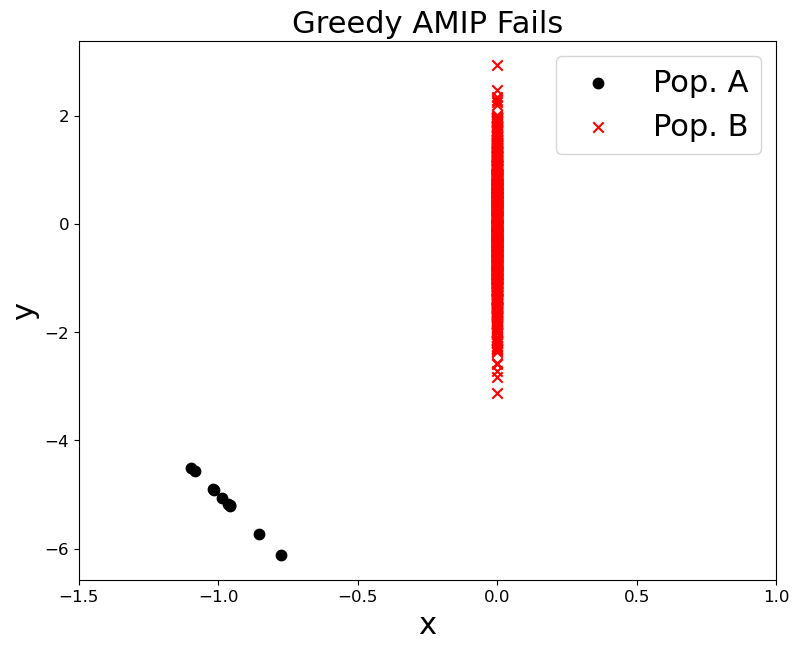

In [13]:
# V. Plot Points Dropped
plt.figure(figsize=(9, 7))
plt.scatter(greedy_fails_df[:10]['x'], greedy_fails_df[:10]['y'], marker='o', color='black', label='Pop. A', s=56) # pop A
plt.scatter(greedy_fails_df[10:]['x'], greedy_fails_df[10:]['y'], marker='x', color='r', label='Pop. B', s=56) # pop B

plt.xlim(-1.5, 1)

plt.xlabel('x', fontsize=22) 
plt.ylabel('y', fontsize=22)  

# Set the size of tick marks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plt.title('Greedy AMIP Fails and Greedy 1sN Succeeds', fontsize=22)
# plt.title('Greedy AMIP and Greedy 1sN Both Fail', fontsize=22)
plt.title('Greedy AMIP Fails', fontsize=22)
plt.legend(fontsize=22)
# plt.savefig("greedy-amip-greedy-newton-fails.pdf")
# plt.savefig("greedy-amip-fails.pdf")
plt.show()

## Net Approx. Algorithm.

In [14]:
'''
For fixed lambda, compute maximum weight of any weight vector w
that has lambda in OLS(X,y,w)
'''
def solve_fixed_lambda(X,XR,lam):
    n = X.shape[0]
    d = X.shape[1]
    c = -np.ones((n))
    A_eq = np.zeros((d,n))
    b_eq = np.zeros((d))
    for i in range(d):
        A_eq[i] = (X.T)[i] * (XR@lam)
    m = gp.Model("net-model")
    m.Params.OutputFlag = 0
    w = m.addMVar(shape=n,vtype=GRB.CONTINUOUS,name="w",lb=0,ub=1)
    m.setObjective(c @ w, GRB.MINIMIZE)
    m.addConstr(A_eq @ w == b_eq)
    m.optimize()
    return w.X

'''
NET UPPER BOUND

Input:
- X: n x d (covariate matrix)
- y: n (response vector)
- trials: integer

Output:
- Net upper bound on Stability(X,y)
'''
def net_algorithm(X,y,trials):
    n = X.shape[0]
    d = X.shape[1]
    XR = np.zeros((d,n))
    for i in range(d-1):
        XR[i] = (X.T)[i+1]
    XR[d-1] = y
    XR = XR.T
    assert(np.linalg.matrix_rank(XR)==d)
    U,s,Vh = scipy.linalg.svd(XR, full_matrices=False)
    A = Vh.T @ np.diag(1.0/s) @ np.eye(d)
    wstar = np.zeros((n))
    for i in range(trials):
        v = np.random.multivariate_normal(np.zeros((d)),np.eye(d))
        v = v / np.linalg.norm(v)
        lam = A@v
        w = solve_fixed_lambda(X,XR,lam)
        if sum(w) > sum(wstar):
            wstar = w
    return n-sum(wstar), wstar


In [15]:
n_sumwstar, wstar = net_algorithm(x[:,1:],y,1000)

Set parameter Username
Set parameter LicenseID to value 2617160
Academic license - for non-commercial use only - expires 2026-02-01


In [16]:
# round the weights returned by NetApprox to 0 or 1.
wstar = np.round(wstar)
mis_inds = np.where(wstar != 1)[0]
print(f"Number of points needed to be removed to zero-out the OLS solution: {len(mis_inds)}")
mis_inds

Number of points needed to be removed to zero-out the OLS solution: 10


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Gurobi Algorithm

In [17]:
model_objbound_frac, model_objval_frac, weights_frac, model_frac = algorithms.solve_regression_fractional(x,y, intercept=True,time_limit=30, warm_start=None, verbose=True,
                               greater_one_constraint=False, pairs=None)
weights_from_fractional_gurobi = np.array([w.X for w in weights_frac])

set residual constraints
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
start solving
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 2000 rows, 1003 columns and 2000 nonzeros
Model fingerprint: 0x7288c859
Model has 4 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e-13, 3e+00]
  QLMatrix range   [5e-09, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2000 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective -0.0000000
Presolve removed 2000 rows and 0 columns
P

In [18]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x,y, intercept=True,time_limit=30, warm_start=weights_from_fractional_gurobi, verbose=True, #beta_sign=1,
                                warm_start_ub=None, pairs = None)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 1004 columns and 1 nonzeros
Model fingerprint: 0x74f4dff2
Model has 4 quadratic constraints
Variable types: 4 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e-13, 1e+01]
  QLMatrix range   [5e-09, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

User MIP start produced solution with objective 998 (0.01s)
Loaded user MIP start with objective 998

Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved

In [19]:
gurobi_weights = np.array([w.X for w in weights])
print(f'size of set to flip the sign: {total_observations - sum(gurobi_weights)}')

size of set to flip the sign: 2.0


In [20]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(gurobi_weights == 0)[0]
indices_to_remove

array([ 70, 425])

In [21]:
# Refit after Removing Flagged Points (AMIP and 1Exact flagged the same points.)
Gurobi_inds= indices_to_remove
new_x_gurobi= np.delete(x, Gurobi_inds, axis=0)
new_y_gurobi= np.delete(y, Gurobi_inds, axis=0)
print(new_x_gurobi.shape)
print(new_y_gurobi.shape)

(998, 3)
(998,)


In [22]:
# Refit after removing the points specified by AMIP and Additive 1sN (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_amip = LinearRegression(x=new_x_gurobi.T, y=new_y_gurobi)
modified_lr_amip.fit()
print(
    f"Estimated beta1 after removing subset specified by Gurobi: {modified_lr_amip.beta[1]}"
)

Estimated beta1 with full dataset: 5.13372787270511
Estimated beta1 after removing subset specified by Gurobi: 5.137900411940101


## The Leverage Algorithm.

In [23]:
# sort leverage scores in descending order.
np.argsort(greedy_fails_df['leverage'][:10])

0    1
1    5
2    4
3    0
4    7
5    6
6    3
7    8
8    9
9    2
Name: leverage, dtype: int64

## Greedy Algorithms.

In [30]:
# store the original x and y.
orig_x = x
orig_y = y
# compute scores for initial round of the greedy algorithm.
orig_df, if_inds, if_scores, newton_inds, newton_scores = linear_regression.create_orig_df(orig_x, orig_y, lr)
# store the original indices of x and y.
orig_inds_if = if_inds
orig_inds_newton = newton_inds

In [32]:
# sample run of the greedy algorithm.
alphaN = 10
dropped_order, exact_changes_beta, beta_estimates_greedy = linear_regression.Run_Greedy(orig_x, orig_y, orig_inds_if, orig_inds_newton, lr, alphaN, method='IF')

print("dropped order: \n", dropped_order)
print("exact (greedy) beta estimates: \n", beta_estimates_greedy)

dropped order: 
 [1, 4, 3, 0, 3, 2, 1, 1, 1, 255]
exact (greedy) beta estimates: 
 [4.9543525646285325, 4.803560471326711, 4.730686372045048, 4.641727336712975, 4.530019154813749, 4.412551481921444, 4.297914457994859, 4.106163421093769, 4.0495214295947575, 4.04087322725687]


In [33]:
len(dropped_order)

10

### Additive Approximations.

In [34]:
# III. Compute influence scores for first coefficient.
# scores = -lr.influence_scores()[0] # effect of removing a data point.
scores = -lr.influence_scores()[1] # after adding an intercept term, take the scores of coefficient 1.
newton_scores = -lr.one_step_newton()[1]

print("A", np.mean(np.abs(scores[:10])), "B", np.mean(np.abs(scores[10:1000])))

# sort indices in ascending order (influence scores are negative, so the largest magnitude scores appear first.)
inds = np.argsort(scores)
print("inds", inds[:10])
original_inds = inds # original_inds

newton_inds = np.argsort(newton_scores)
print("newton inds", newton_inds[:10])
original_newton_inds = newton_inds 

# sort scores.
sorted_scores = scores[inds]
print("sorted_scores", sorted(scores)[:10])
original_sorted_scores = sorted_scores

sorted_newton_scores = newton_scores[inds]
print("sorted_newton_scores", sorted_newton_scores[:10])
original_sorted_newton_scores = sorted_newton_scores

# residuals
residuals = lr.residual()
print("residuals", residuals[:10])
# leverages
leverages = lr.leverage_scores()
print("leverages", leverages[:10])


# x's
intercept = [pt[0] for pt in x]
x1 = [pt[1] for pt in x]
x2 = [pt[2] for pt in x]

# x1 = [pt[0] for pt in x]
# x2 = [pt[1] for pt in x]

# create a df with residuals, leverages, and coordinates.
orig_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y, 
                                  'residual': residuals, 'leverage': leverages, 
                        'influence': scores, 'newton': newton_scores})
orig_df[:10]

A 0.06866862773989695 B 0.0009056829785818775
inds [  1   5   4   0   7 769 512 109 554 207]
newton inds [  1   5   4   0   7 769 512 109 554 207]
sorted_scores [-0.16803000598257914, -0.11592628648350757, -0.023459757826731615, -0.020714022024682883, -0.015208585122114164, -0.0056123414574106335, -0.005392407853523847, -0.005286696660208167, -0.005192720040701295, -0.004976423621113326]
sorted_newton_scores [-0.17937531 -0.12559482 -0.02599087 -0.02295144 -0.01686366 -0.00563682
 -0.00541536 -0.00532172 -0.0052073  -0.00499798]
residuals [-0.20770636 -2.07850417  1.18886667  0.34553861 -0.23123655 -1.28715366
  0.06754415 -0.14948974  0.40383164  1.05325707]
leverages [0.09748496 0.06324896 0.12716731 0.10803622 0.09738457 0.07698195
 0.10231626 0.09814461 0.10953977 0.12398494]


,x1,x2,y,residual,leverage,influence,newton
0,-0.959984,1.764052,-5.200079,-0.207706,0.097485,-0.020714,-0.022951
1,-0.775911,0.978738,-6.120447,-2.078504,0.063249,-0.168030,-0.179375
2,-1.097728,1.867558,-4.511361,1.188867,0.127167,0.135930,0.155735
3,-1.015136,0.950088,-4.924321,0.345539,0.108036,0.036772,0.041226
4,-0.958940,-0.103219,-5.205299,-0.231237,0.097385,-0.023460,-0.025991
5,-0.854573,0.144044,-5.727137,-1.287154,0.076982,-0.115926,-0.125595
6,-0.987832,0.761038,-5.060838,0.067544,0.102316,0.007004,0.007802
7,-0.966633,0.443863,-5.166837,-0.149490,0.098145,-0.015209,-0.016864
8,-1.020516,1.494079,-4.897421,0.403832,0.109540,0.042991,0.048280
9,-1.085410,0.313068,-4.572952,1.053257,0.123985,0.120651,0.137727


In [35]:
# (4/01) Sum of influence and newton scores for population A
print(f"additive influence score for pop A: {sum(sorted_scores[:10])}")
print(f"additive one-step newton score for pop A: {sum(sorted_newton_scores[:10])}")

print(f'indices sorted according to influence score: {original_inds[:10]}')
print(f'indices sorted according to newton score: {original_newton_inds[:10]}')

additive influence score for pop A: -0.3697992470725726
additive one-step newton score for pop A: -0.39735528650731833
indices sorted according to influence score: [  1   5   4   0   7 769 512 109 554 207]
indices sorted according to newton score: [  1   5   4   0   7 769 512 109 554 207]


In [36]:
# print a list of discrepancies between additive one step newton and influence:
discrepant_indices = [i for i in range(len(original_inds)) if original_inds[i] != original_newton_inds[i]]
discrepant_indices[:5]

[56, 57, 82, 83, 113]

In [37]:
# IV. Sort DF by influence score
sorted_if_df = orig_df.sort_values(by='influence', ascending=True)
# sorted_if_df # the indices here are the order which amip drops points.
index = range(0, len(sorted_if_df))
sorted_if_df['sorted_idx'] = index
sorted_if_df[:10]

,x1,x2,y,residual,leverage,influence,newton,sorted_idx
1,-0.775911,0.978738,-6.120447,-2.078504,0.063249,-0.168030,-0.179375,0
5,-0.854573,0.144044,-5.727137,-1.287154,0.076982,-0.115926,-0.125595,1
4,-0.958940,-0.103219,-5.205299,-0.231237,0.097385,-0.023460,-0.025991,2
0,-0.959984,1.764052,-5.200079,-0.207706,0.097485,-0.020714,-0.022951,3
7,-0.966633,0.443863,-5.166837,-0.149490,0.098145,-0.015209,-0.016864,4
769,-0.000009,1.740629,1.960881,2.024840,0.004343,-0.005612,-0.005637,5
512,-0.000025,1.712305,1.902618,1.966462,0.004237,-0.005392,-0.005415,6
109,-0.000001,2.259309,1.542796,1.610312,0.006581,-0.005287,-0.005322,7
554,0.000016,1.267412,2.188619,2.249168,0.002800,-0.005193,-0.005207,8
207,0.000022,1.732721,1.734572,1.798318,0.004314,-0.004976,-0.004998,9


In [28]:
def plot_dropped_point(x, y, index_to_remove):
    '''
    orig_df: df sorted by original indexing (where the outlier population comes first).
    index_to_drop: index returned from sorting by influence (or one-step newton) scores.
    method: "influence" or "newton"
    '''
    
    # V. Plot Dropped Point at Current Iteration
    plt.figure(figsize=(9, 7))
    plt.scatter(x.T[1][index_to_remove], y[index_to_remove], marker='x', color='black', label='Dropped point')
    
    # match the window of the original plot.
    plt.xlim(-2, 0.05)
    plt.ylim(-7, 3)
    
    plt.xlabel('x1')
    plt.ylabel('y')
    plt.title('Dropped Point')
    plt.legend()
    
    plt.show()
    
    return

In [26]:
def create_orig_df(x, lr):
    '''
    x: design matrix.
    lr: linear regression object.
    '''
    scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order (influence scores are negative, so the largest magnitude scores appear first.)
    inds = np.argsort(scores)
    # print("inds", inds[:10])
    original_inds = inds # original_inds

    newton_inds = np.argsort(newton_scores)
    # print("newton inds", newton_inds[:10])
    original_newton_inds = newton_inds 

    # sort scores.
    sorted_scores = scores[inds]
    # print("sorted_scores", sorted(scores)[:10])
    original_sorted_scores = sorted_scores

    sorted_newton_scores = newton_scores[inds]
    # print("sorted_newton_scores", sorted_newton_scores[:10])
    original_sorted_newton_scores = sorted_newton_scores

    # residuals
    residuals = lr.residual()
    # print("residuals", residuals[:10])
    # leverages
    leverages = lr.leverage_scores()
    # print("leverages", leverages[:10])

    # x's
    intercept = [pt[0] for pt in x]
    x1 = [pt[1] for pt in x]
    x2 = [pt[2] for pt in x]

    # x1 = [pt[0] for pt in x]
    # x2 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y, 
                                      'residual': residuals, 'leverage': leverages, 
                            'influence': scores, 'newton': newton_scores})
    
    print(orig_df[:10])
    
    return orig_df, inds, scores, newton_inds, newton_scores


In [27]:
def create_plot(orig_df):
    '''
    orig_df: output from the helper function above.
    '''
    
    # IV. Sort DF by influence score
    sorted_if_df = orig_df.sort_values(by='influence', ascending=True)
    print("index 0 in create_plot", sorted_if_df.index[0])
    
    # sorted_if_df # the indices here are the order which amip drops points.
    index = range(0, len(sorted_if_df))
    
    sorted_if_df['sorted_idx'] = index
    
    # V. Plot Points Dropped
    plt.figure(figsize=(9, 7))

    plt.scatter(orig_df[:10]['x1'], orig_df[:10]['y'], marker='x', color='black', label='Pop. A') # pop A
    plt.scatter(orig_df[10:]['x1'], orig_df[10:]['y'], marker='x', color='r', label='Pop. B') # pop B


#     # Add dropped order positioned by each point
#     for index, row in sorted_if_df.iterrows():
#         if row['sorted_idx'] <= 9: # indices 2,3,4 are right on top of one another.
#             plt.text(row['x1'], row['y'], int(row['sorted_idx']), ha='left', va='top', fontsize=20)


    plt.xlabel('x1')
    plt.ylabel('y')
    plt.title('Scores Ordered')
    plt.legend()
    plt.show()
    
    return

Greedy 1sN failure: If we have k outliers (where k is large), each of the individual leverage terms cannot be very large because they are divided among k points (i.e. leverage can be at most 1/k). Hence, the residual * leverage * (1/(1-leverage)) term may not exceed the residual * leverage terms of some of the inliers (despite the leverage correction). 

This repeat k-points centered around one dot (where k is large) manufactures a case where the residuals are small in the outlier cluster and the leverage is also small (if k is large enough).

interation 0
index to remove 1


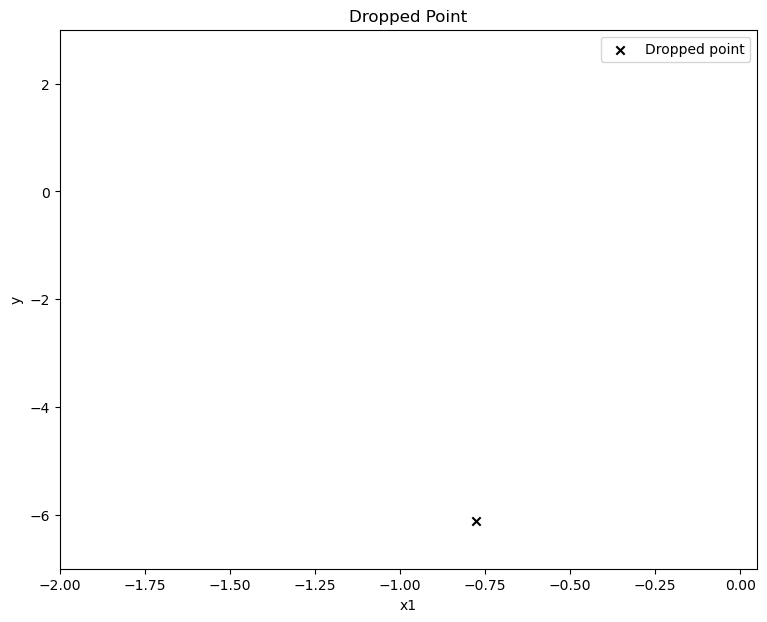

fitted beta1: 4.9543525646285325
         x1        x2         y  residual  leverage  influence    newton
0 -0.959984  1.764052 -5.200079 -0.381602  0.104042  -0.040637 -0.045356
1 -1.097728  1.867558 -4.511361  0.990192  0.135726   0.120866  0.139847
2 -1.015136  0.950088 -4.924321  0.162308  0.115316   0.018429  0.020831
3 -0.958940 -0.103219 -5.205299 -0.403666  0.103831  -0.043660 -0.048719
4 -0.854573  0.144044 -5.727137 -1.441031  0.082116  -0.138410 -0.150792
5 -0.987832  0.761038 -5.060838 -0.110660  0.109202  -0.012241 -0.013742
6 -0.966633  0.443863 -5.166837 -0.323674  0.104723  -0.035122 -0.039231
7 -1.020516  1.494079 -4.897421  0.219263  0.116926   0.024916  0.028215
8 -1.085410  0.313068 -4.572952  0.857857  0.132264   0.104788  0.120760
9  0.000021 -2.552990 -1.532921 -1.497628  0.007769  -0.002099 -0.002115
index 0 in create_plot 4


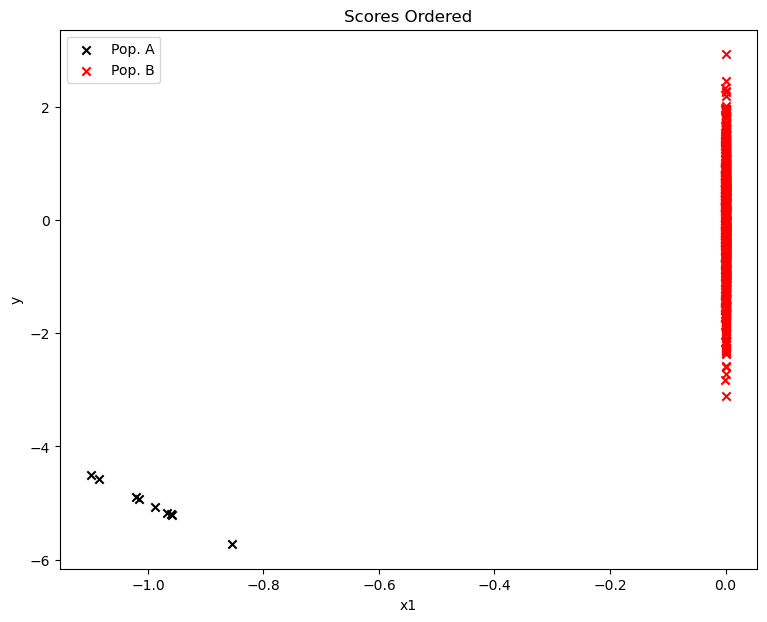

interation 1
index to remove 4


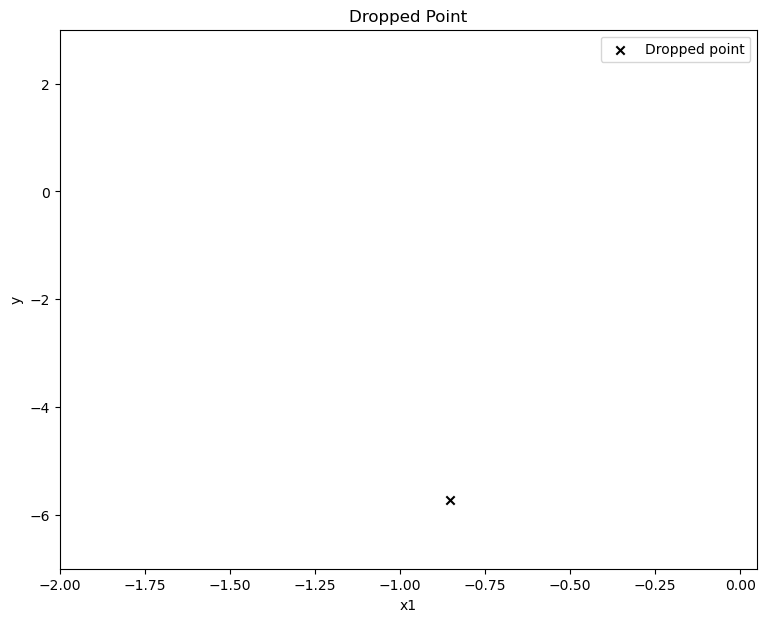

fitted beta1: 4.803560471326711
         x1        x2         y  residual  leverage  influence    newton
0 -0.959984  1.764052 -5.200079 -0.524807  0.113107  -0.060897 -0.068663
1 -1.097728  1.867558 -4.511361  0.826319  0.147596   0.109889  0.128916
2 -1.015136  0.950088 -4.924321  0.009978  0.125573   0.001234  0.001412
3 -0.958940 -0.103219 -5.205299 -0.548567  0.113112  -0.064631 -0.072874
4 -0.987832  0.761038 -5.060838 -0.259060  0.118937  -0.031220 -0.035434
5 -0.966633  0.443863 -5.166837 -0.469192  0.114083  -0.055463 -0.062606
6 -1.020516  1.494079 -4.897421  0.066662  0.127220   0.008253  0.009456
7 -1.085410  0.313068 -4.572952  0.694298  0.144088   0.092378  0.107929
8  0.000021 -2.552990 -1.532921 -1.500358  0.007772  -0.002375 -0.002394
9 -0.000023  0.864436 -1.711970 -1.654444  0.001862   0.003159  0.003165
index 0 in create_plot 3


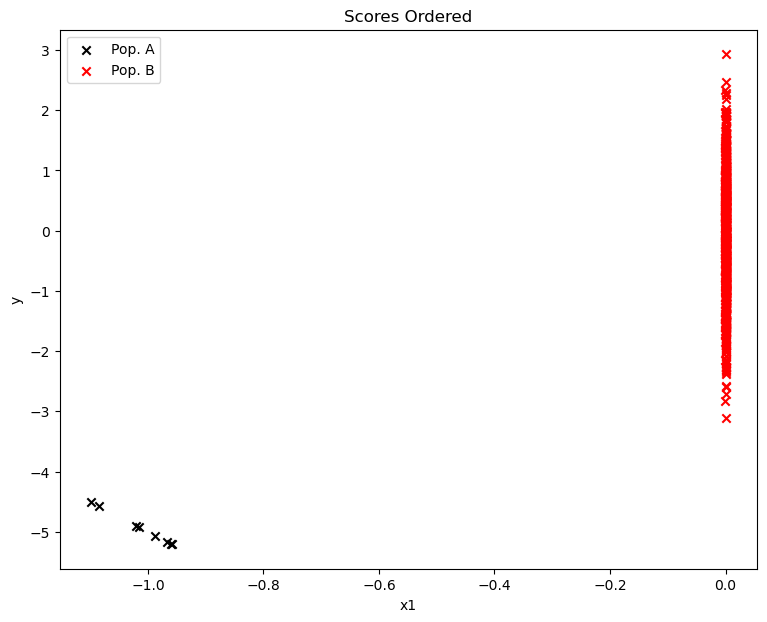

interation 2
index to remove 3


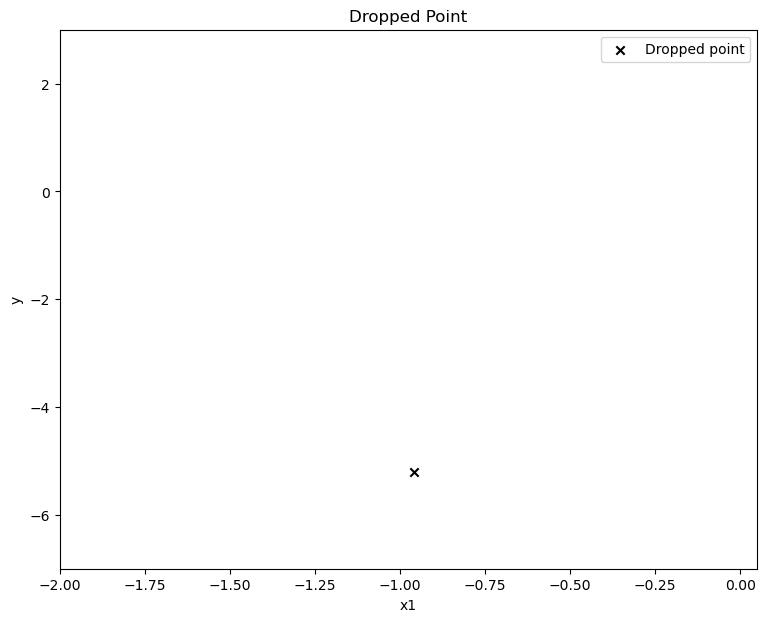

fitted beta1: 4.730686372045048
         x1        x2         y  residual  leverage  influence    newton
0 -0.959984  1.764052 -5.200079 -0.593624  0.127064  -0.077656 -0.088959
1 -1.097728  1.867558 -4.511361  0.747532  0.165890   0.112061  0.134348
2 -1.015136  0.950088 -4.924321 -0.063391  0.141437  -0.008840 -0.010297
3 -0.987832  0.761038 -5.060838 -0.330563  0.134005  -0.044913 -0.051863
4 -0.966633  0.443863 -5.166837 -0.539358  0.128593  -0.071886 -0.082494
5 -1.020516  1.494079 -4.897421 -0.006743  0.143100  -0.000941 -0.001098
6 -1.085410  0.313068 -4.572952  0.615391  0.162439   0.092308  0.110211
7  0.000021 -2.552990 -1.532921 -1.502042  0.007780  -0.002921 -0.002944
8 -0.000023  0.864436 -1.711970 -1.653894  0.001863   0.003354  0.003360
9 -0.000046  2.269755  0.046135  0.115416  0.006641  -0.000423 -0.000425
index 0 in create_plot 0


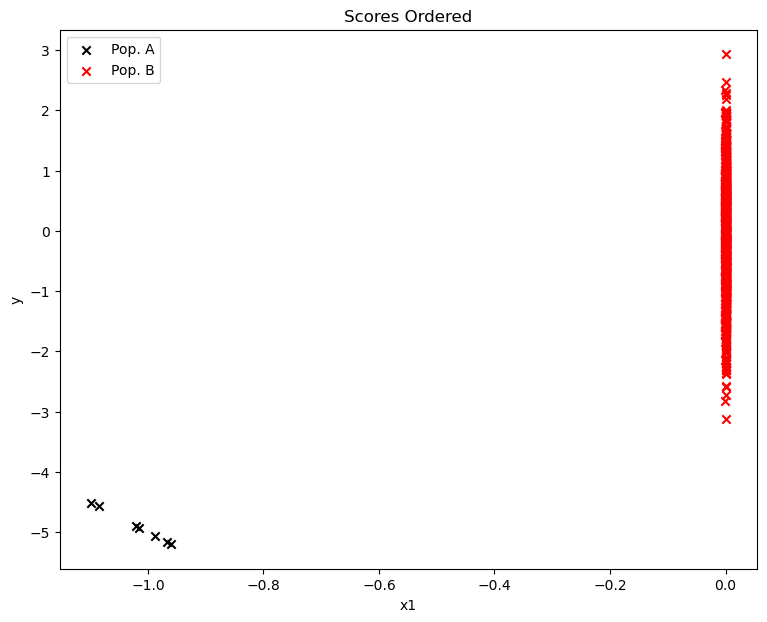

interation 3
index to remove 0


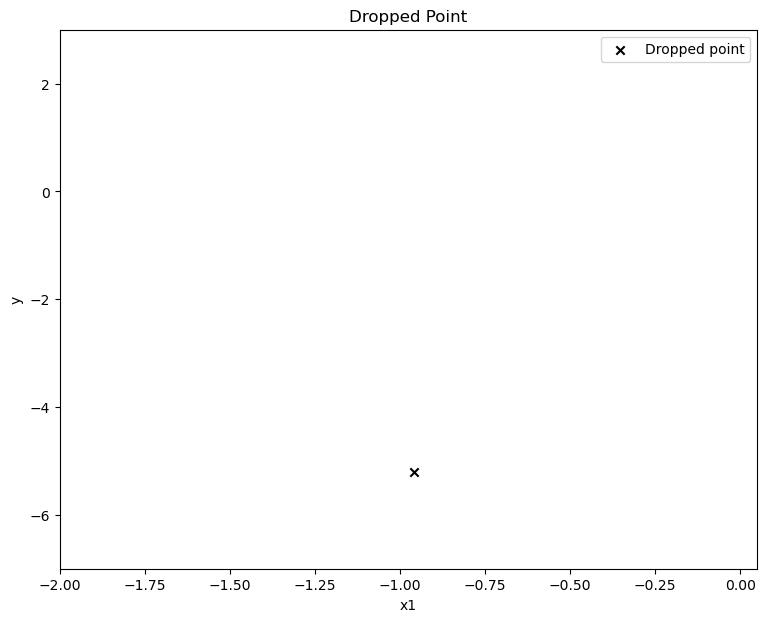

fitted beta1: 4.641727336712975
         x1        x2         y  residual  leverage  influence    newton
0 -1.097728  1.867558 -4.511361  0.648816  0.190031   0.111377  0.137507
1 -1.015136  0.950088 -4.924321 -0.154266  0.161895  -0.024603 -0.029355
2 -0.987832  0.761038 -5.060838 -0.418907  0.153338  -0.065072 -0.076857
3 -0.966633  0.443863 -5.166837 -0.625645  0.147037  -0.095283 -0.111708
4 -1.020516  1.494079 -4.897421 -0.098389  0.163906  -0.015720 -0.018801
5 -1.085410  0.313068 -4.572952  0.518608  0.185643   0.088852  0.109106
6  0.000021 -2.552990 -1.532921 -1.500723  0.007785  -0.002483 -0.002502
7 -0.000023  0.864436 -1.711970 -1.654419  0.001863   0.003163  0.003169
8 -0.000046  2.269755  0.046135  0.114132  0.006645  -0.000385 -0.000388
9 -0.000006  0.045759 -0.958374 -0.906929  0.001016   0.000960  0.000961
index 0 in create_plot 3


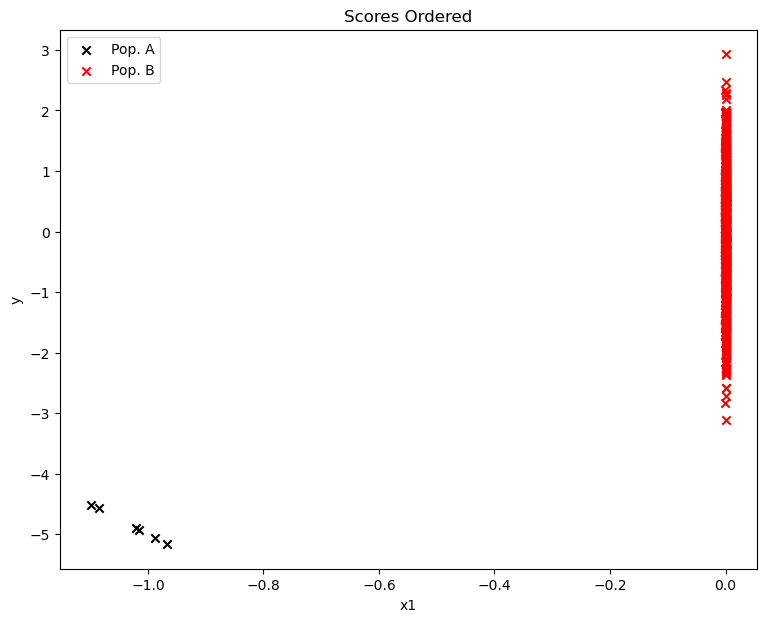

interation 4
index to remove 3


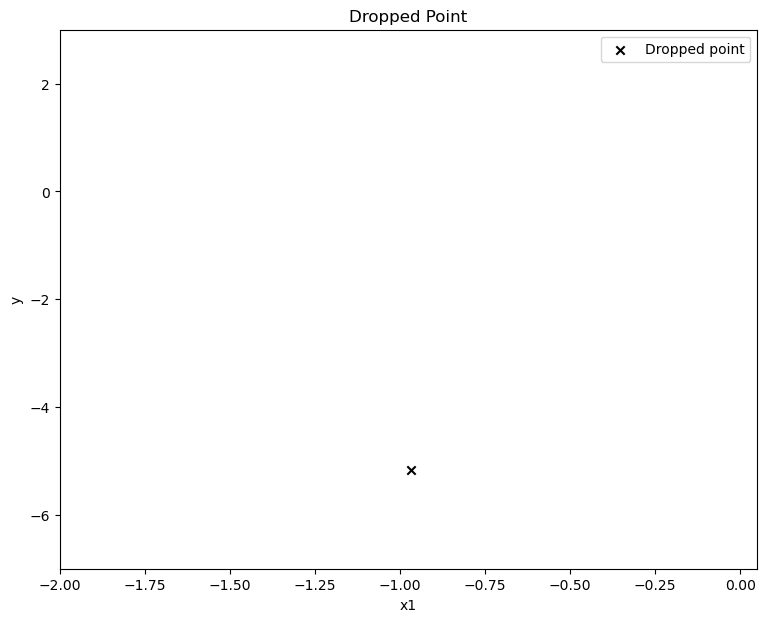

fitted beta1: 4.530019154813749
         x1        x2         y  residual  leverage  influence    newton
0 -1.097728  1.867558 -4.511361  0.526848  0.222447   0.106081  0.136430
1 -1.015136  0.950088 -4.924321 -0.267348  0.189760  -0.049996 -0.061706
2 -0.987832  0.761038 -5.060838 -0.529009  0.179754  -0.096352 -0.117468
3 -1.020516  1.494079 -4.897421 -0.211870  0.191968  -0.039703 -0.049135
4 -1.085410  0.313068 -4.572952  0.397440  0.217635   0.079815  0.102017
5  0.000021 -2.552990 -1.532921 -1.501701  0.007787  -0.002842 -0.002864
6 -0.000023  0.864436 -1.711970 -1.654136  0.001863   0.003276  0.003283
7 -0.000046  2.269755  0.046135  0.114933  0.006647  -0.000411 -0.000413
8 -0.000006  0.045759 -0.958374 -0.906948  0.001016   0.000956  0.000957
9  0.000046  1.532779 -0.080812 -0.018129  0.003614   0.000050  0.000050
index 0 in create_plot 2


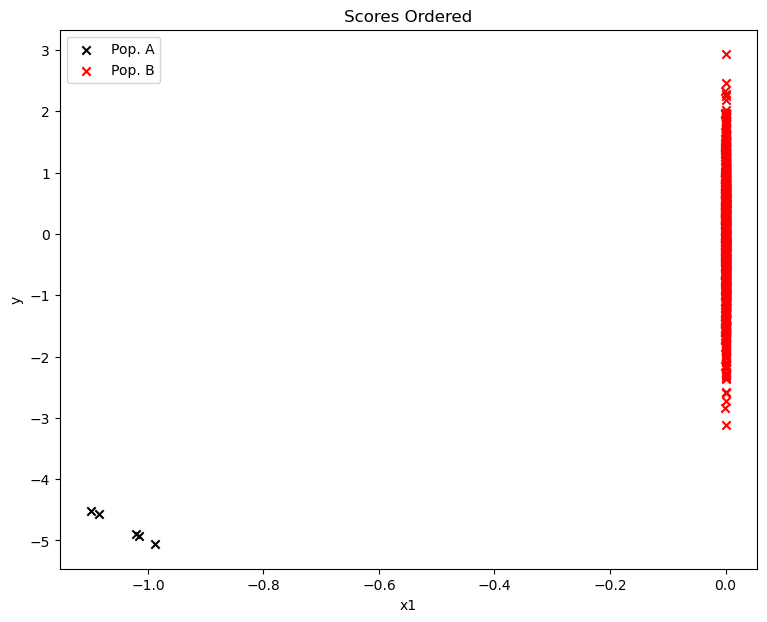

interation 5
index to remove 2


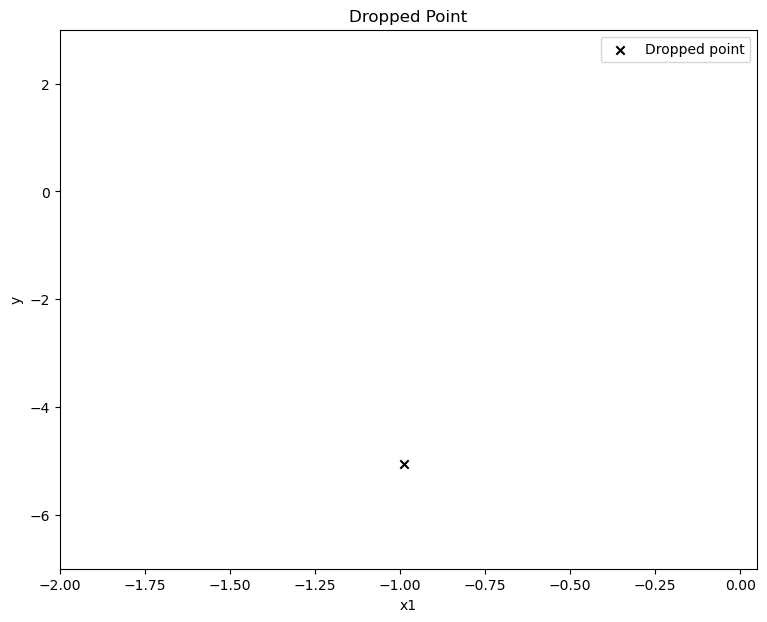

fitted beta1: 4.412551481921444
         x1        x2         y  residual  leverage  influence    newton
0 -1.097728  1.867558 -4.511361  0.398207  0.270951   0.097816  0.134170
1 -1.015136  0.950088 -4.924321 -0.386451  0.231338  -0.088117 -0.114637
2 -1.020516  1.494079 -4.897421 -0.331508  0.233921  -0.075778 -0.098916
3 -1.085410  0.313068 -4.572952  0.269967  0.265263   0.066064  0.089915
4  0.000021 -2.552990 -1.532921 -1.502187  0.007787  -0.003094 -0.003118
5 -0.000023  0.864436 -1.711970 -1.654013  0.001863   0.003347  0.003353
6 -0.000046  2.269755  0.046135  0.115307  0.006647  -0.000427 -0.000430
7 -0.000006  0.045759 -0.958374 -0.906969  0.001016   0.000949  0.000950
8  0.000046  1.532779 -0.080812 -0.017877  0.003614   0.000051  0.000051
9  0.000012  0.154947 -0.703859 -0.651669  0.001047   0.000770  0.000771
index 0 in create_plot 1


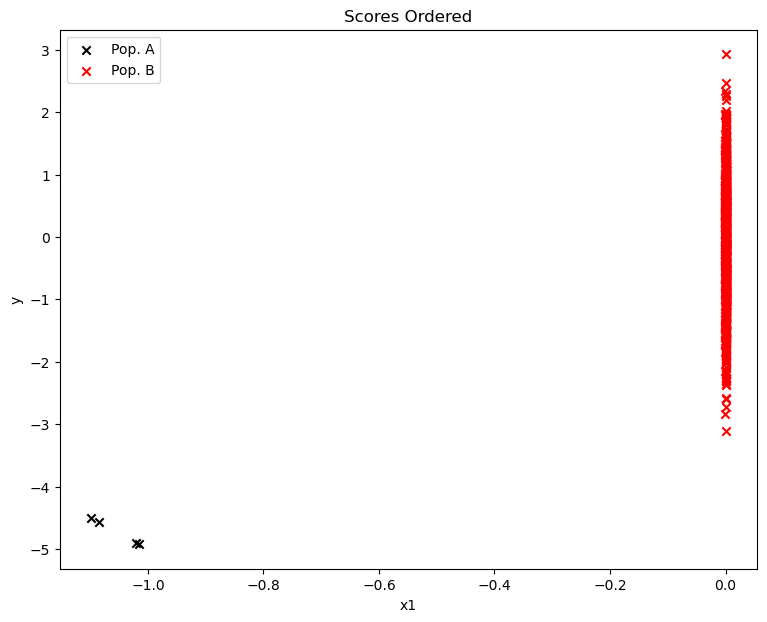

interation 6
index to remove 1


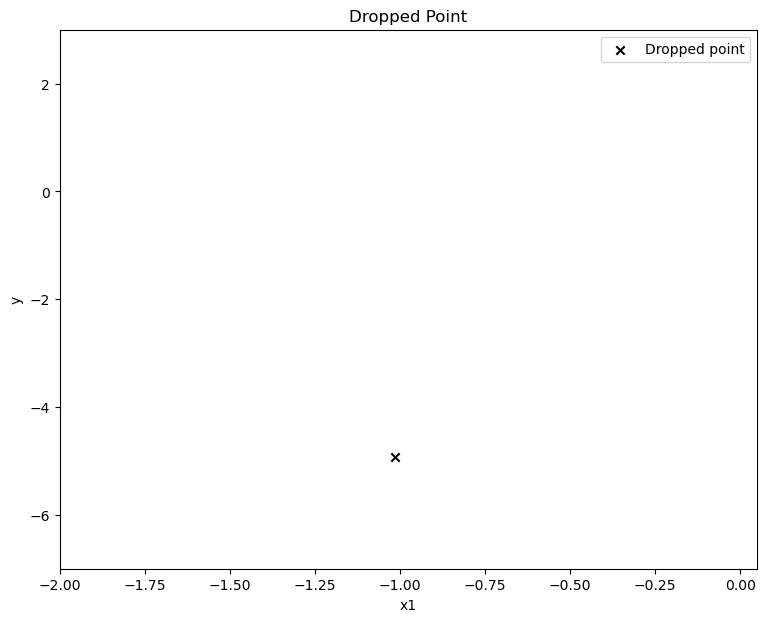

fitted beta1: 4.297914457994859
         x1        x2         y  residual  leverage  influence    newton
0 -1.097728  1.867558 -4.511361  0.272510  0.352270   0.087150  0.134548
1 -1.020516  1.494079 -4.897421 -0.448386  0.304229  -0.133415 -0.191751
2 -1.085410  0.313068 -4.572952  0.145548  0.344936   0.046302  0.070683
3  0.000021 -2.552990 -1.532921 -1.502421  0.007788  -0.003302 -0.003328
4 -0.000023  0.864436 -1.711970 -1.653958  0.001863   0.003400  0.003406
5 -0.000046  2.269755  0.046135  0.115480  0.006647  -0.000439 -0.000442
6 -0.000006  0.045759 -0.958374 -0.906983  0.001016   0.000942  0.000943
7  0.000046  1.532779 -0.080812 -0.017757  0.003614   0.000052  0.000052
8  0.000012  0.154947 -0.703859 -0.651672  0.001047   0.000769  0.000770
9 -0.000063 -0.887786 -0.770784 -0.726613  0.001793  -0.000104 -0.000104
index 0 in create_plot 1


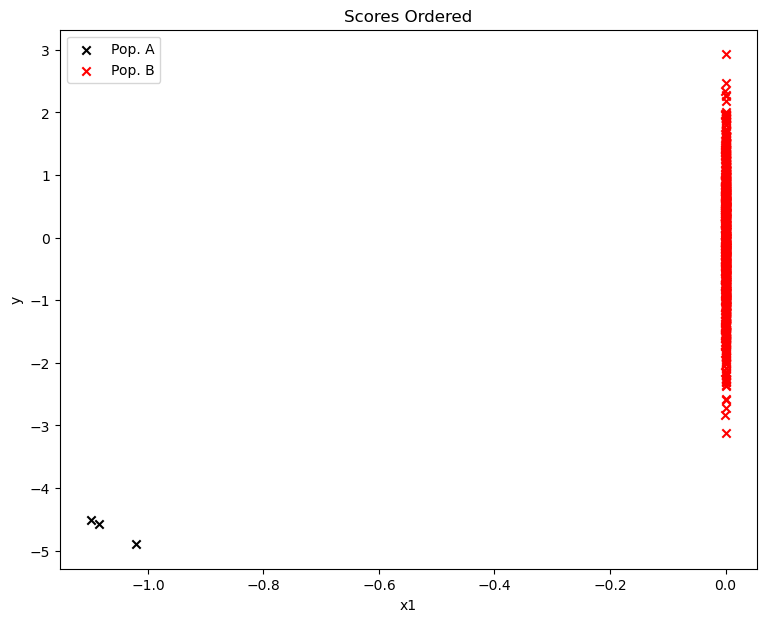

interation 7
index to remove 1


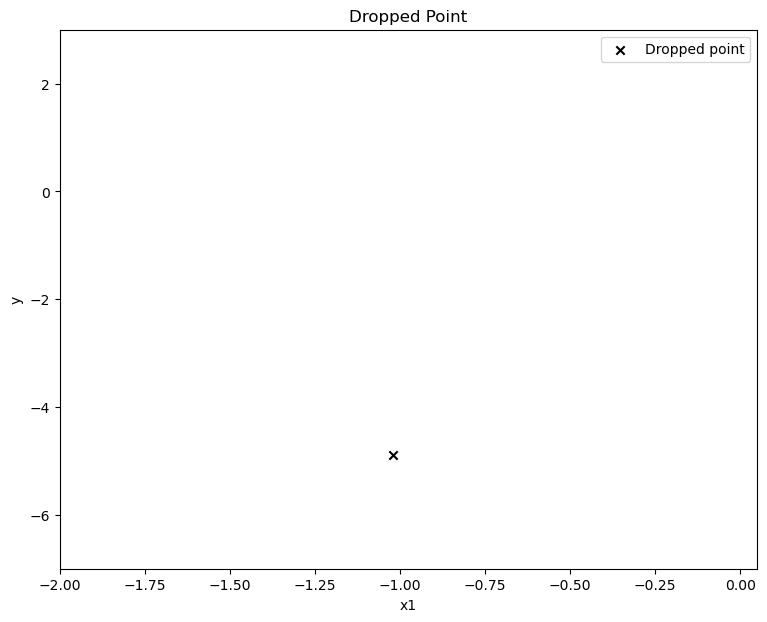

fitted beta1: 4.106163421093769
         x1        x2         y  residual  leverage  influence    newton
0 -1.097728  1.867558 -4.511361  0.061562  0.506268   0.028306  0.057330
1 -1.085410  0.313068 -4.572952 -0.062687  0.494998  -0.028604 -0.056642
2  0.000021 -2.552990 -1.532921 -1.501877  0.007789  -0.002759 -0.002780
3 -0.000023  0.864436 -1.711970 -1.654194  0.001864   0.003141  0.003147
4 -0.000046  2.269755  0.046135  0.114922  0.006648  -0.000395 -0.000397
5 -0.000006  0.045759 -0.958374 -0.907031  0.001016   0.000913  0.000914
6  0.000046  1.532779 -0.080812 -0.018130  0.003615   0.000048  0.000048
7  0.000012  0.154947 -0.703859 -0.651741  0.001047   0.000739  0.000740
8 -0.000063 -0.887786 -0.770784 -0.726461  0.001793  -0.000031 -0.000031
9  0.000005 -0.347912 -0.480845 -0.432605  0.001117   0.000251  0.000251
index 0 in create_plot 1


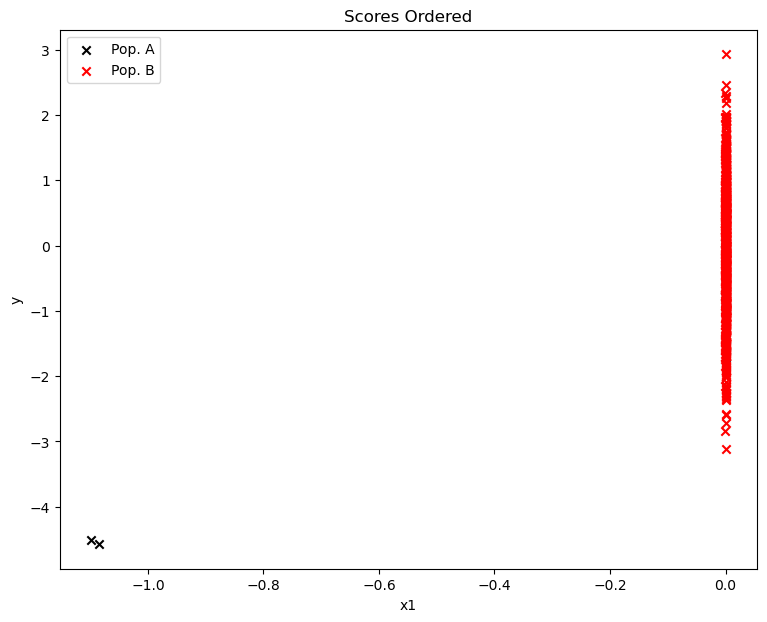

interation 8
index to remove 1


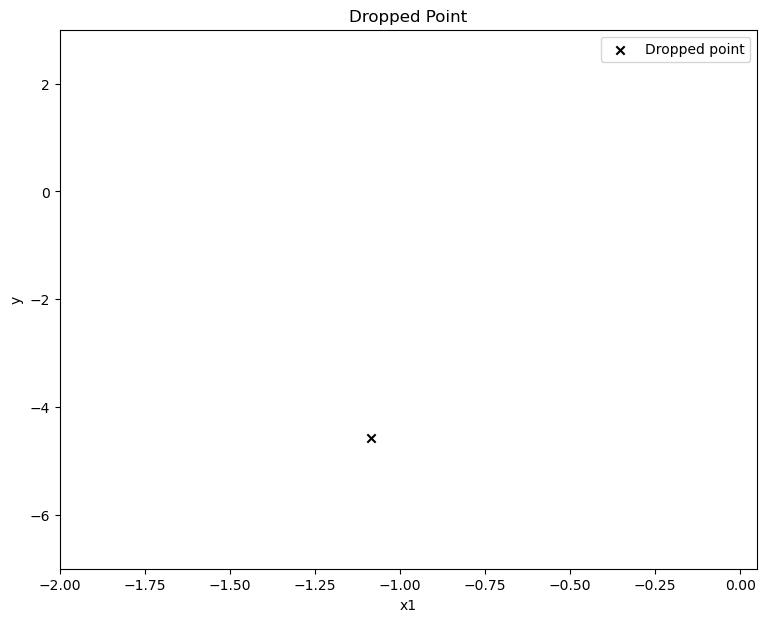

fitted beta1: 4.0495214295947575
         x1        x2         y  residual  leverage  influence      newton
0 -1.097728  1.867558 -4.511361 -0.000421  0.999999  -0.000384 -484.884612
1  0.000021 -2.552990 -1.532921 -1.502135  0.007797  -0.005582   -0.005626
2 -0.000023  0.864436 -1.711970 -1.654104  0.001865   0.004222    0.004230
3 -0.000046  2.269755  0.046135  0.115155  0.006655  -0.000590   -0.000594
4 -0.000006  0.045759 -0.958374 -0.907024  0.001016   0.000958    0.000959
5  0.000046  1.532779 -0.080812 -0.017968  0.003618   0.000069    0.000069
6  0.000012  0.154947 -0.703859 -0.651722  0.001047   0.000830    0.000830
7 -0.000063 -0.887786 -0.770784 -0.726553  0.001794  -0.000518   -0.000519
8  0.000005 -0.347912 -0.480845 -0.432638  0.001117   0.000147    0.000147
9  0.000038  1.230291  0.703586  0.764082  0.002707  -0.002505   -0.002512
index 0 in create_plot 255


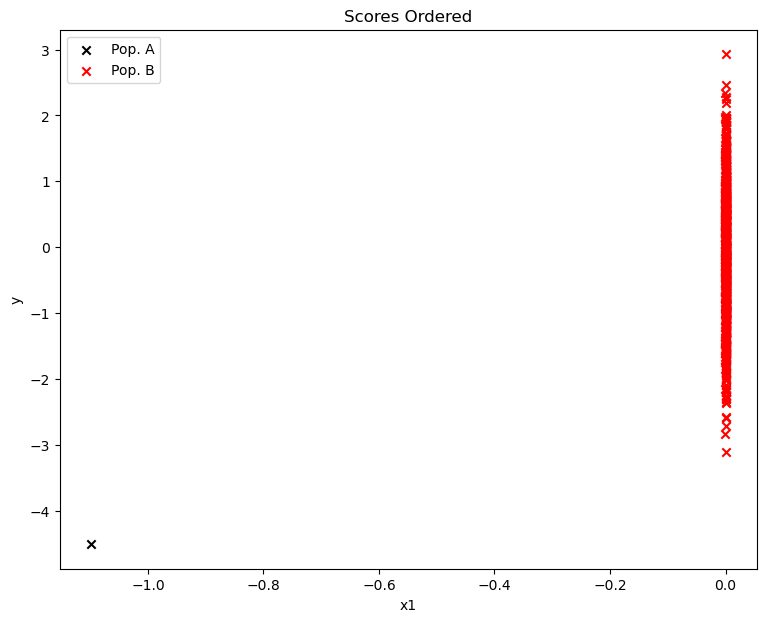

interation 9
index to remove 255


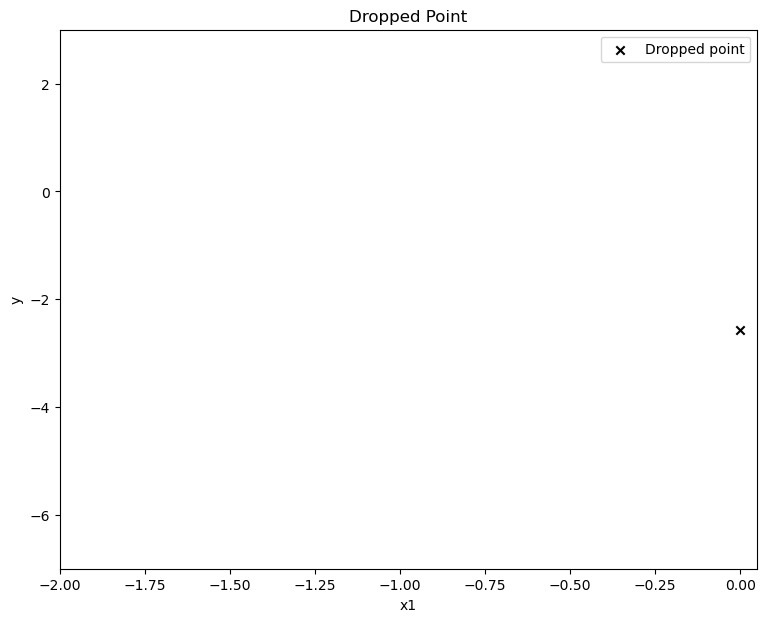

fitted beta1: 4.04087322725687
         x1        x2         y  residual  leverage  influence      newton
0 -1.097728  1.867558 -4.511361 -0.000359  0.999999  -0.000327 -413.686718
1  0.000021 -2.552990 -1.532921 -1.520865  0.007851  -0.005690   -0.005735
2 -0.000023  0.864436 -1.711970 -1.650967  0.001866   0.004221    0.004229
3 -0.000046  2.269755  0.046135  0.127283  0.006678  -0.000655   -0.000659
4 -0.000006  0.045759 -0.958374 -0.909126  0.001017   0.000958    0.000959
5  0.000046  1.532779 -0.080812 -0.010554  0.003627   0.000041    0.000041
6  0.000012  0.154947 -0.703859 -0.653124  0.001047   0.000830    0.000831
7 -0.000063 -0.887786 -0.770784 -0.734628  0.001804  -0.000532   -0.000533
8  0.000005 -0.347912 -0.480845 -0.437258  0.001121   0.000146    0.000146
9  0.000038  1.230291  0.703586  0.769561  0.002711  -0.002529   -0.002536
index 0 in create_plot 759


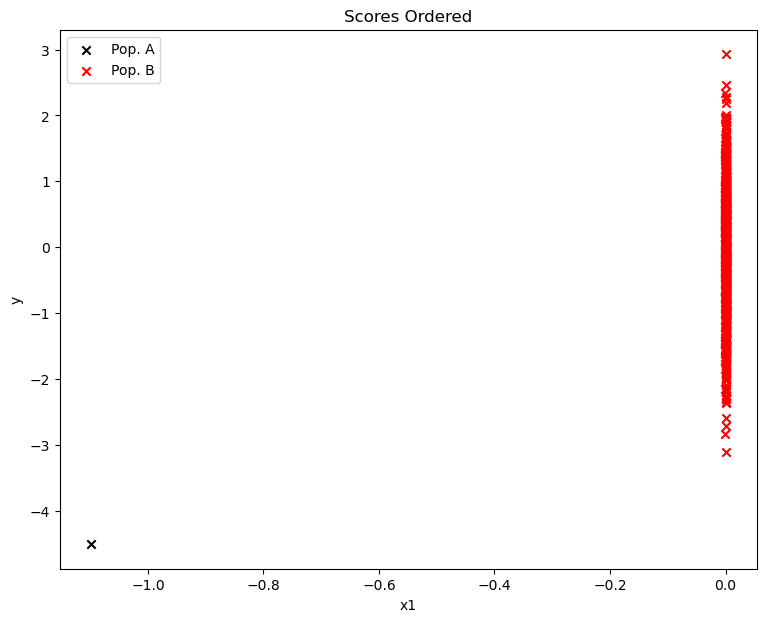

interation 10
index to remove 759


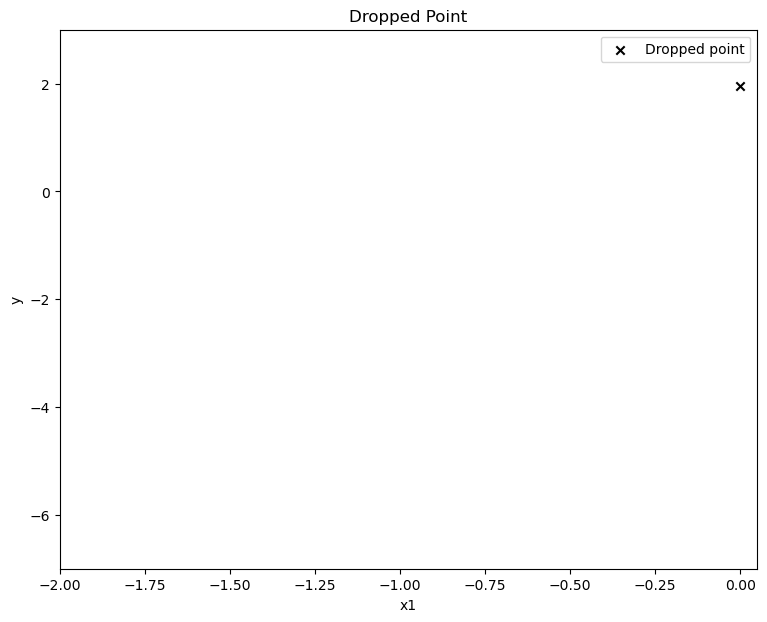

fitted beta1: 4.032306556839654
         x1        x2         y  residual  leverage  influence      newton
0 -1.097728  1.867558 -4.511361 -0.000344  0.999999  -0.000314 -396.315005
1  0.000021 -2.552990 -1.532921 -1.528591  0.007865  -0.005743   -0.005789
2 -0.000023  0.864436 -1.711970 -1.645439  0.001874   0.004226    0.004234
3 -0.000046  2.269755  0.046135  0.138262  0.006707  -0.000714   -0.000719
4 -0.000006  0.045759 -0.958374 -0.906772  0.001018   0.000960    0.000961
5  0.000046  1.532779 -0.080812 -0.002433  0.003642   0.000009    0.000009
6  0.000012  0.154947 -0.703859 -0.650347  0.001049   0.000830    0.000831
7 -0.000063 -0.887786 -0.770784 -0.735896  0.001804  -0.000535   -0.000536
8  0.000005 -0.347912 -0.480845 -0.436432  0.001121   0.000146    0.000146
9  0.000038  1.230291  0.703586  0.776508  0.002723  -0.002563   -0.002570
index 0 in create_plot 100


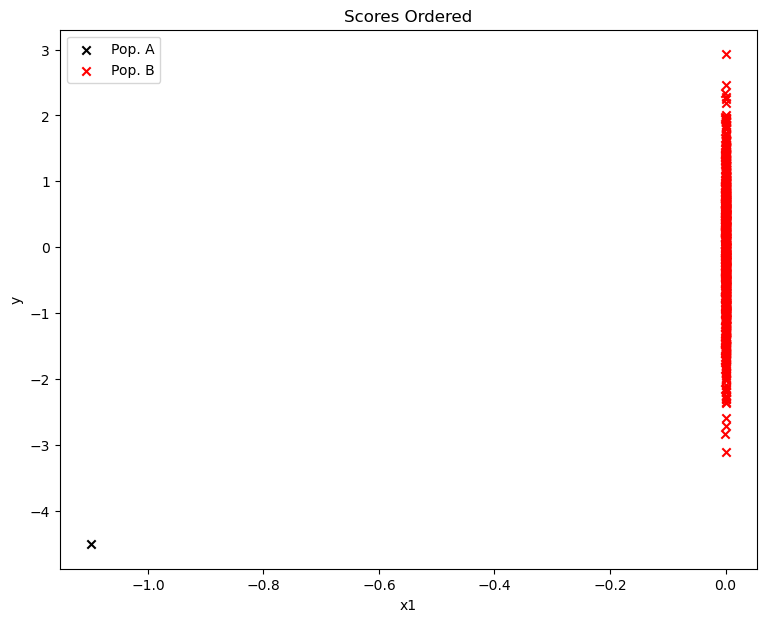

interation 11
index to remove 100


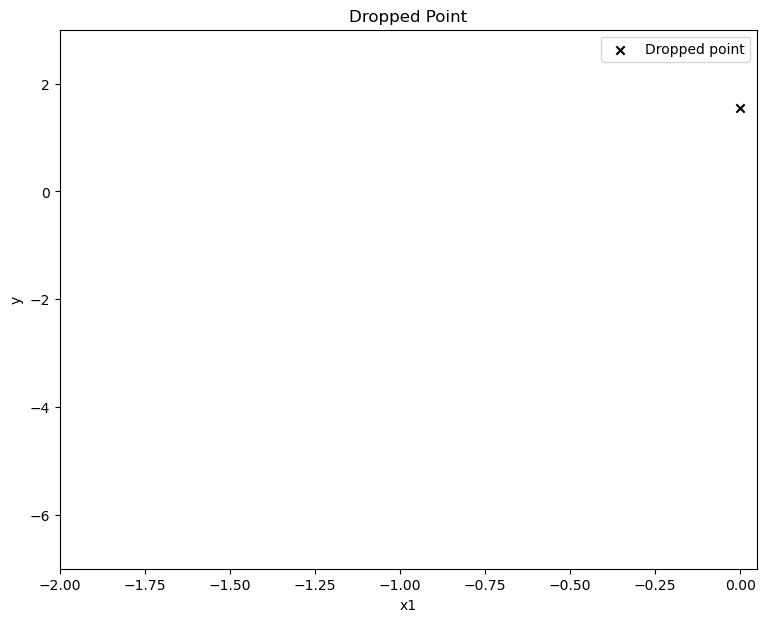

fitted beta1: 4.02377746804454
last point standing: -0.0003135658049255652
         x1        x2         y  residual  leverage  influence      newton
0 -1.097728  1.867558 -4.511361 -0.000344  0.999999  -0.000314 -396.307332
1  0.000021 -2.552990 -1.532921 -1.537158  0.007893  -0.005817   -0.005863
2 -0.000023  0.864436 -1.711970 -1.640146  0.001884   0.004240    0.004248
3 -0.000046  2.269755  0.046135  0.149255  0.006752  -0.000776   -0.000781
4 -0.000006  0.045759 -0.958374 -0.904799  0.001020   0.000964    0.000965
5  0.000046  1.532779 -0.080812  0.005572  0.003666  -0.000022   -0.000022
6  0.000012  0.154947 -0.703859 -0.647931  0.001051   0.000832    0.000833
7 -0.000063 -0.887786 -0.770784 -0.737710  0.001806  -0.000540   -0.000541
8  0.000005 -0.347912 -0.480845 -0.436055  0.001121   0.000147    0.000147
9  0.000038  1.230291  0.703586  0.783287  0.002740  -0.002602   -0.002609
index 0 in create_plot 501


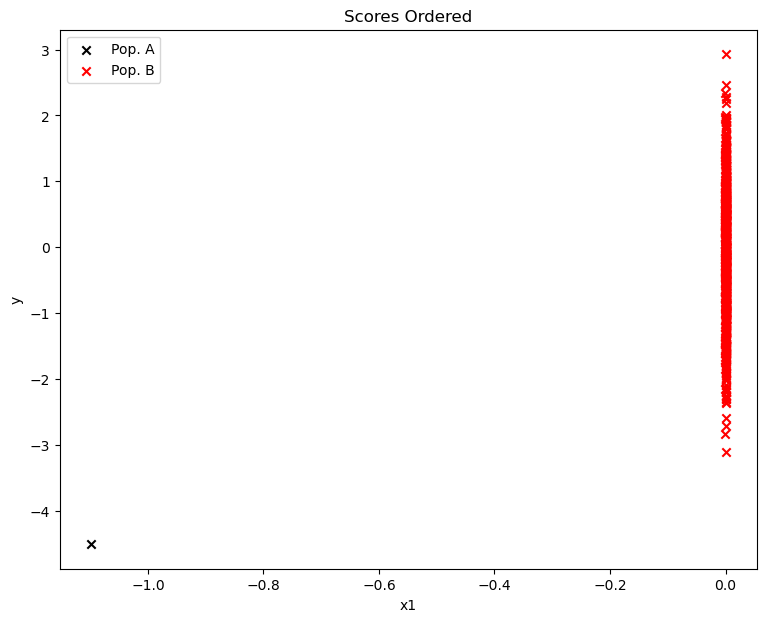

dropped order: 
 [1, 4, 3, 0, 3, 2, 1, 1, 1, 255, 759, 100]
exact (greedy) beta estimates: 
 [4.9543525646285325, 4.803560471326711, 4.730686372045048, 4.641727336712975, 4.530019154813749, 4.412551481921444, 4.297914457994859, 4.106163421093769, 4.0495214295947575, 4.04087322725687, 4.032306556839654, 4.02377746804454]


In [38]:
# reset greedy loop.
x = orig_x
y = orig_y

### BEGIN GREEDY AMIP LOOP (inds, x, y)
alpha = 0.01
ctr = 0
prev_beta = lr.beta[1] # initialize to the original beta estimate.
dropped_order = []
exact_changes_beta = []
beta_estimates_greedy = []
inds = original_inds # (4/01) start with the indices sorted according to the first round.


# while lr.beta[1] >= 0:
for _ in range(12):
    print(f'interation {ctr}')

    # 1. drop the datapoint with the most negative influence:
    index_to_remove = inds[0]
    print("index to remove", index_to_remove)
    
    ### (4/08) plot the dropped point.
    plot_dropped_point(x, y, index_to_remove)
    
    dropped_order.append(index_to_remove)

    new_x = np.concatenate((x[:index_to_remove], x[index_to_remove + 1:]))
    new_y = np.concatenate((y[:index_to_remove], y[index_to_remove + 1:]))

    x = new_x
    y = new_y

    # 2. calculate the exact perturbation (ie. refit the lr to get the change in the coefficient.)
    lr = LinearRegression(x=x.T, y=y)
    lr.fit()
    print(f'fitted beta1: {lr.beta[1]}')

    # 3. compute ranked influence scores for all datapoints remaining.
    if ctr == 11:
        print("last point standing:", scores[0])
    
    ### (4/01) CREATE PLOT.
    orig_df, inds, scores, newton_inds, newton_scores = create_orig_df(x, lr)
    # print(f"x, y, leverage, residual, is, 1sN:\n {(orig_df['x1'][index_to_remove],orig_df['y'][index_to_remove], orig_df['leverage'][index_to_remove], orig_df['residual'][index_to_remove], orig_df['influence'][index_to_remove], orig_df['newton'][index_to_remove])}")
    create_plot(orig_df)

    # 4. record: the exact change in beta.
    beta_change = lr.beta[1] - prev_beta
    exact_changes_beta.append(beta_change)
    prev_beta = lr.beta[1]
    beta_estimates_greedy.append(lr.beta[1])

    # counter
    ctr += 1

#### Finish loop and print.
print("dropped order: \n", dropped_order[:15]) # (4/01) see if this is in the first 10 points. -> yep, it is.
print("exact (greedy) beta estimates: \n", beta_estimates_greedy[:15])
####

interation 0
index to remove 1


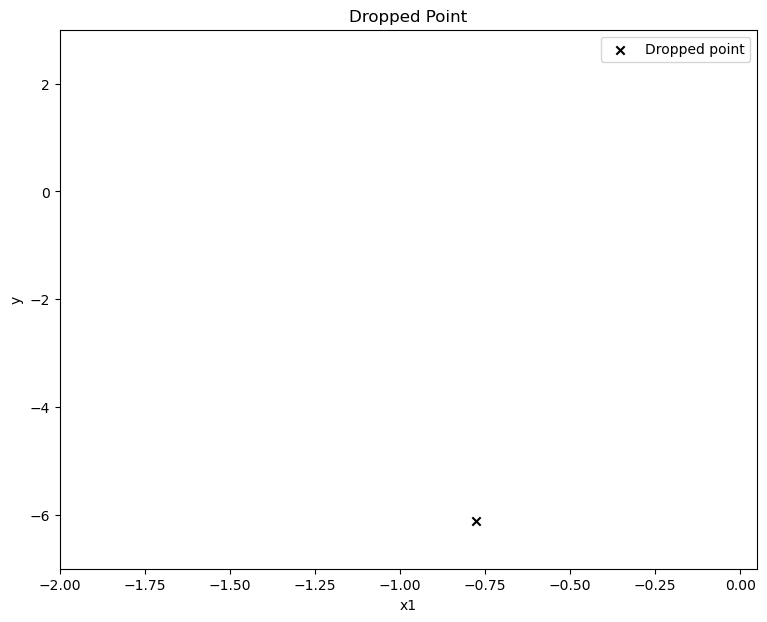

fitted beta1: 4.9543525646285325
         x1        x2         y  residual  leverage  influence    newton
0 -0.959984  1.764052 -5.200079 -0.381602  0.104042  -0.040637 -0.045356
1 -1.097728  1.867558 -4.511361  0.990192  0.135726   0.120866  0.139847
2 -1.015136  0.950088 -4.924321  0.162308  0.115316   0.018429  0.020831
3 -0.958940 -0.103219 -5.205299 -0.403666  0.103831  -0.043660 -0.048719
4 -0.854573  0.144044 -5.727137 -1.441031  0.082116  -0.138410 -0.150792
5 -0.987832  0.761038 -5.060838 -0.110660  0.109202  -0.012241 -0.013742
6 -0.966633  0.443863 -5.166837 -0.323674  0.104723  -0.035122 -0.039231
7 -1.020516  1.494079 -4.897421  0.219263  0.116926   0.024916  0.028215
8 -1.085410  0.313068 -4.572952  0.857857  0.132264   0.104788  0.120760
9  0.000021 -2.552990 -1.532921 -1.497628  0.007769  -0.002099 -0.002115
index 0 in create_plot 4


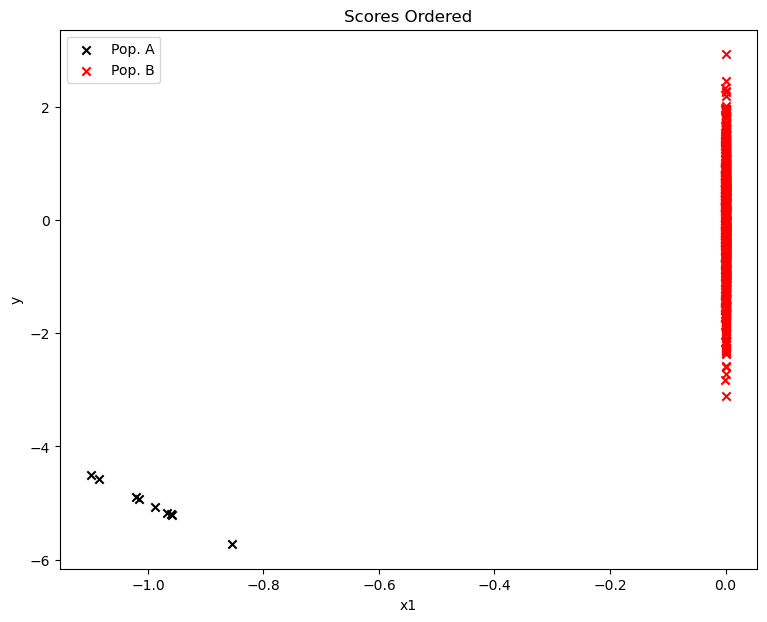

interation 1
index to remove 4


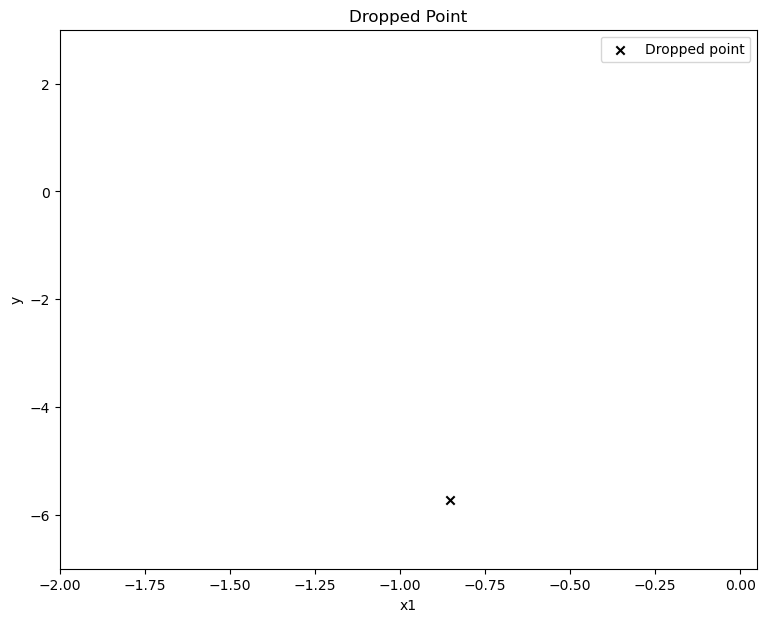

fitted beta1: 4.803560471326711
         x1        x2         y  residual  leverage  influence    newton
0 -0.959984  1.764052 -5.200079 -0.524807  0.113107  -0.060897 -0.068663
1 -1.097728  1.867558 -4.511361  0.826319  0.147596   0.109889  0.128916
2 -1.015136  0.950088 -4.924321  0.009978  0.125573   0.001234  0.001412
3 -0.958940 -0.103219 -5.205299 -0.548567  0.113112  -0.064631 -0.072874
4 -0.987832  0.761038 -5.060838 -0.259060  0.118937  -0.031220 -0.035434
5 -0.966633  0.443863 -5.166837 -0.469192  0.114083  -0.055463 -0.062606
6 -1.020516  1.494079 -4.897421  0.066662  0.127220   0.008253  0.009456
7 -1.085410  0.313068 -4.572952  0.694298  0.144088   0.092378  0.107929
8  0.000021 -2.552990 -1.532921 -1.500358  0.007772  -0.002375 -0.002394
9 -0.000023  0.864436 -1.711970 -1.654444  0.001862   0.003159  0.003165
index 0 in create_plot 3


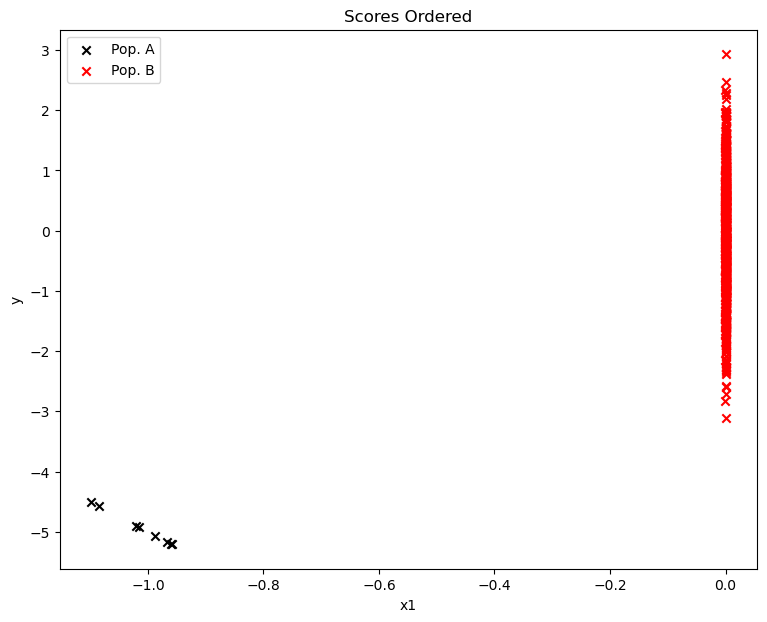

interation 2
index to remove 3


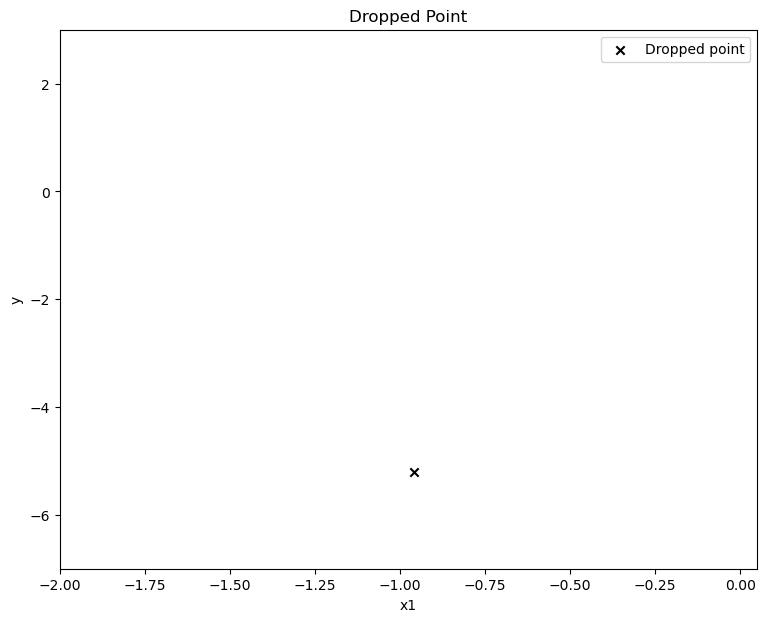

fitted beta1: 4.730686372045048
         x1        x2         y  residual  leverage  influence    newton
0 -0.959984  1.764052 -5.200079 -0.593624  0.127064  -0.077656 -0.088959
1 -1.097728  1.867558 -4.511361  0.747532  0.165890   0.112061  0.134348
2 -1.015136  0.950088 -4.924321 -0.063391  0.141437  -0.008840 -0.010297
3 -0.987832  0.761038 -5.060838 -0.330563  0.134005  -0.044913 -0.051863
4 -0.966633  0.443863 -5.166837 -0.539358  0.128593  -0.071886 -0.082494
5 -1.020516  1.494079 -4.897421 -0.006743  0.143100  -0.000941 -0.001098
6 -1.085410  0.313068 -4.572952  0.615391  0.162439   0.092308  0.110211
7  0.000021 -2.552990 -1.532921 -1.502042  0.007780  -0.002921 -0.002944
8 -0.000023  0.864436 -1.711970 -1.653894  0.001863   0.003354  0.003360
9 -0.000046  2.269755  0.046135  0.115416  0.006641  -0.000423 -0.000425
index 0 in create_plot 0


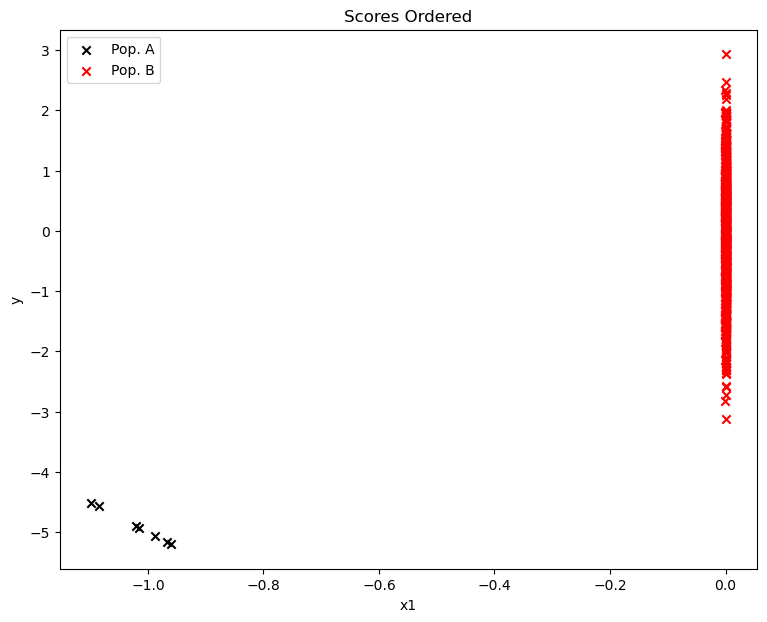

interation 3
index to remove 0


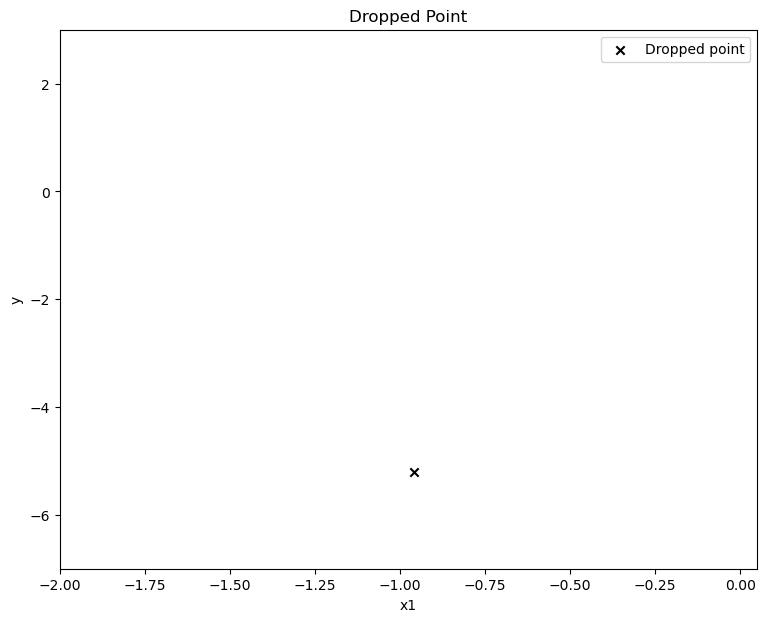

fitted beta1: 4.641727336712975
         x1        x2         y  residual  leverage  influence    newton
0 -1.097728  1.867558 -4.511361  0.648816  0.190031   0.111377  0.137507
1 -1.015136  0.950088 -4.924321 -0.154266  0.161895  -0.024603 -0.029355
2 -0.987832  0.761038 -5.060838 -0.418907  0.153338  -0.065072 -0.076857
3 -0.966633  0.443863 -5.166837 -0.625645  0.147037  -0.095283 -0.111708
4 -1.020516  1.494079 -4.897421 -0.098389  0.163906  -0.015720 -0.018801
5 -1.085410  0.313068 -4.572952  0.518608  0.185643   0.088852  0.109106
6  0.000021 -2.552990 -1.532921 -1.500723  0.007785  -0.002483 -0.002502
7 -0.000023  0.864436 -1.711970 -1.654419  0.001863   0.003163  0.003169
8 -0.000046  2.269755  0.046135  0.114132  0.006645  -0.000385 -0.000388
9 -0.000006  0.045759 -0.958374 -0.906929  0.001016   0.000960  0.000961
index 0 in create_plot 3


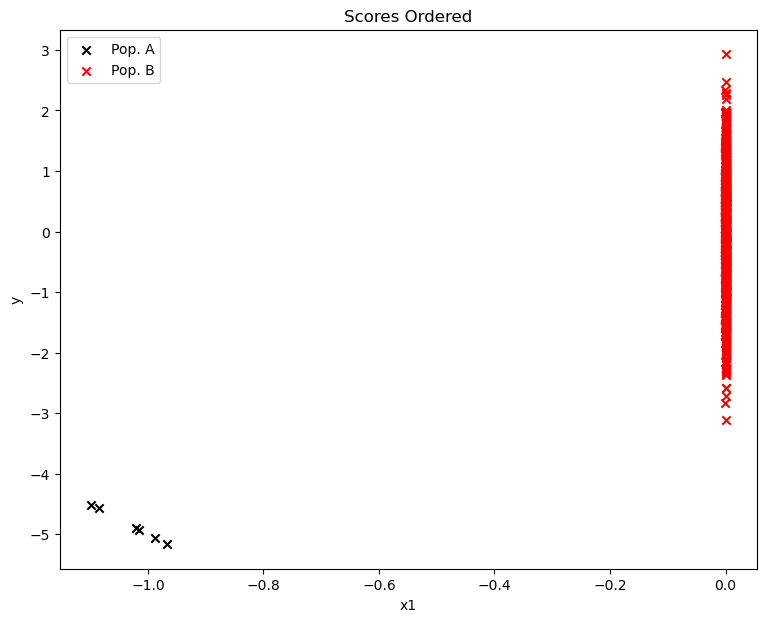

interation 4
index to remove 3


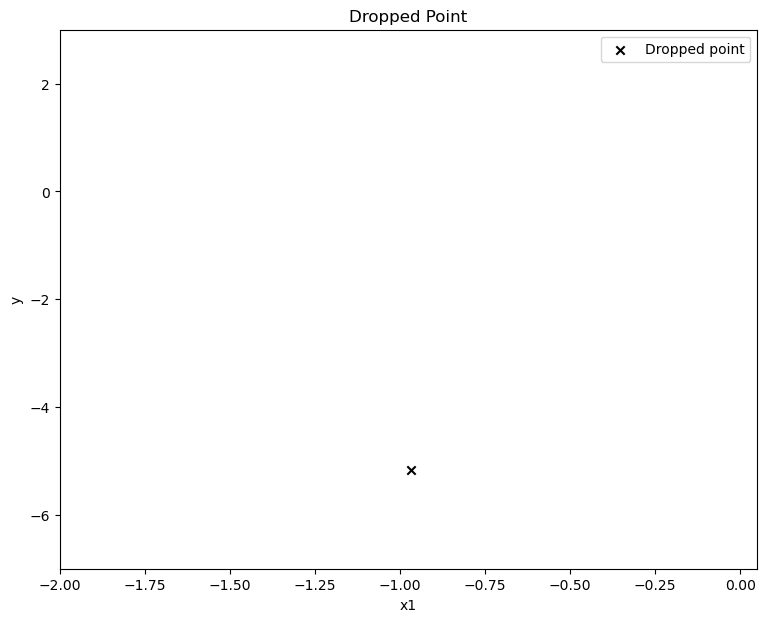

fitted beta1: 4.530019154813749
         x1        x2         y  residual  leverage  influence    newton
0 -1.097728  1.867558 -4.511361  0.526848  0.222447   0.106081  0.136430
1 -1.015136  0.950088 -4.924321 -0.267348  0.189760  -0.049996 -0.061706
2 -0.987832  0.761038 -5.060838 -0.529009  0.179754  -0.096352 -0.117468
3 -1.020516  1.494079 -4.897421 -0.211870  0.191968  -0.039703 -0.049135
4 -1.085410  0.313068 -4.572952  0.397440  0.217635   0.079815  0.102017
5  0.000021 -2.552990 -1.532921 -1.501701  0.007787  -0.002842 -0.002864
6 -0.000023  0.864436 -1.711970 -1.654136  0.001863   0.003276  0.003283
7 -0.000046  2.269755  0.046135  0.114933  0.006647  -0.000411 -0.000413
8 -0.000006  0.045759 -0.958374 -0.906948  0.001016   0.000956  0.000957
9  0.000046  1.532779 -0.080812 -0.018129  0.003614   0.000050  0.000050
index 0 in create_plot 2


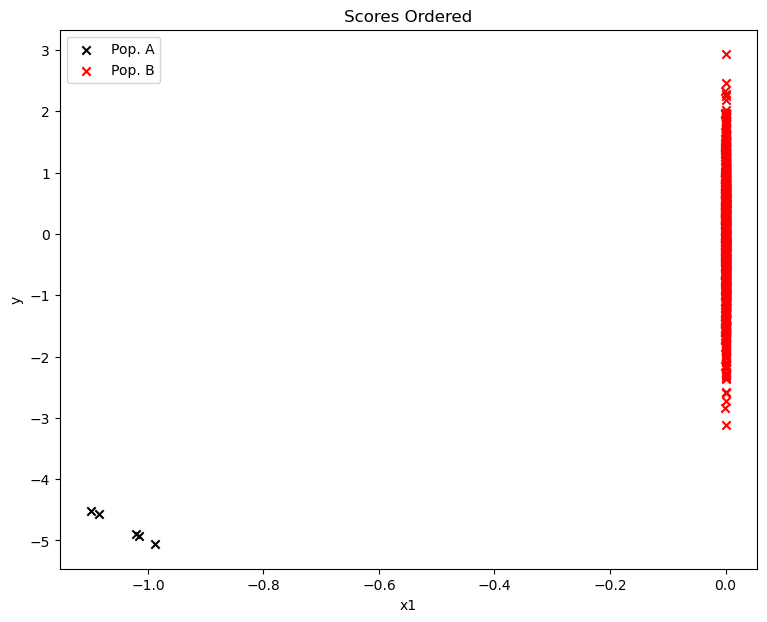

interation 5
index to remove 2


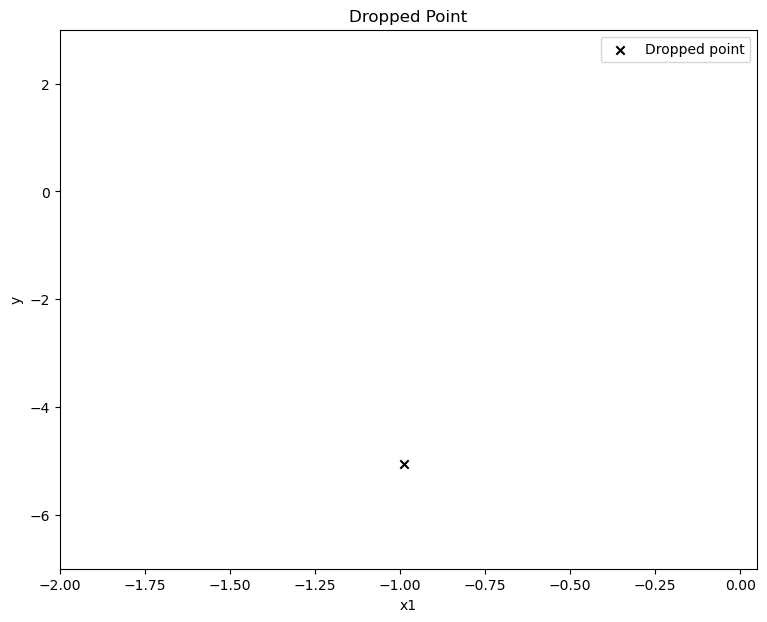

fitted beta1: 4.412551481921444
         x1        x2         y  residual  leverage  influence    newton
0 -1.097728  1.867558 -4.511361  0.398207  0.270951   0.097816  0.134170
1 -1.015136  0.950088 -4.924321 -0.386451  0.231338  -0.088117 -0.114637
2 -1.020516  1.494079 -4.897421 -0.331508  0.233921  -0.075778 -0.098916
3 -1.085410  0.313068 -4.572952  0.269967  0.265263   0.066064  0.089915
4  0.000021 -2.552990 -1.532921 -1.502187  0.007787  -0.003094 -0.003118
5 -0.000023  0.864436 -1.711970 -1.654013  0.001863   0.003347  0.003353
6 -0.000046  2.269755  0.046135  0.115307  0.006647  -0.000427 -0.000430
7 -0.000006  0.045759 -0.958374 -0.906969  0.001016   0.000949  0.000950
8  0.000046  1.532779 -0.080812 -0.017877  0.003614   0.000051  0.000051
9  0.000012  0.154947 -0.703859 -0.651669  0.001047   0.000770  0.000771
index 0 in create_plot 1


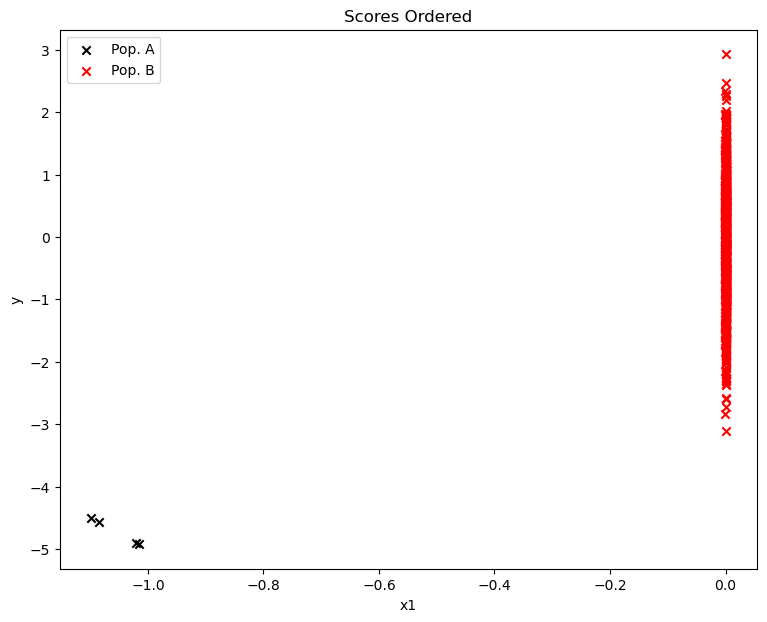

interation 6
index to remove 1


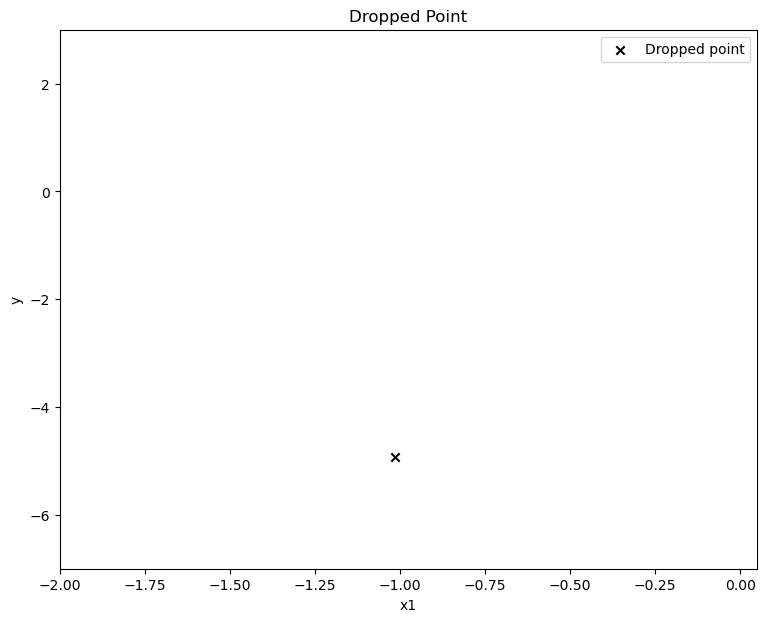

fitted beta1: 4.297914457994859
         x1        x2         y  residual  leverage  influence    newton
0 -1.097728  1.867558 -4.511361  0.272510  0.352270   0.087150  0.134548
1 -1.020516  1.494079 -4.897421 -0.448386  0.304229  -0.133415 -0.191751
2 -1.085410  0.313068 -4.572952  0.145548  0.344936   0.046302  0.070683
3  0.000021 -2.552990 -1.532921 -1.502421  0.007788  -0.003302 -0.003328
4 -0.000023  0.864436 -1.711970 -1.653958  0.001863   0.003400  0.003406
5 -0.000046  2.269755  0.046135  0.115480  0.006647  -0.000439 -0.000442
6 -0.000006  0.045759 -0.958374 -0.906983  0.001016   0.000942  0.000943
7  0.000046  1.532779 -0.080812 -0.017757  0.003614   0.000052  0.000052
8  0.000012  0.154947 -0.703859 -0.651672  0.001047   0.000769  0.000770
9 -0.000063 -0.887786 -0.770784 -0.726613  0.001793  -0.000104 -0.000104
index 0 in create_plot 1


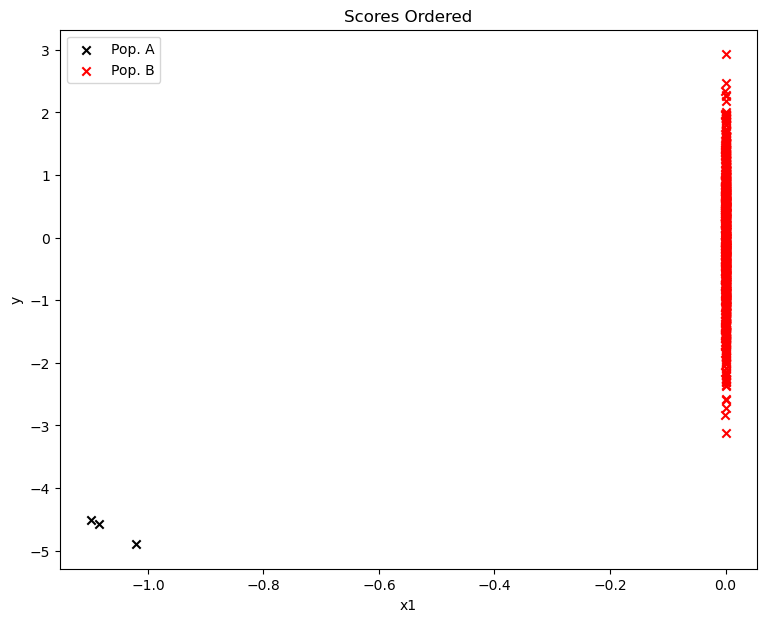

interation 7
index to remove 1


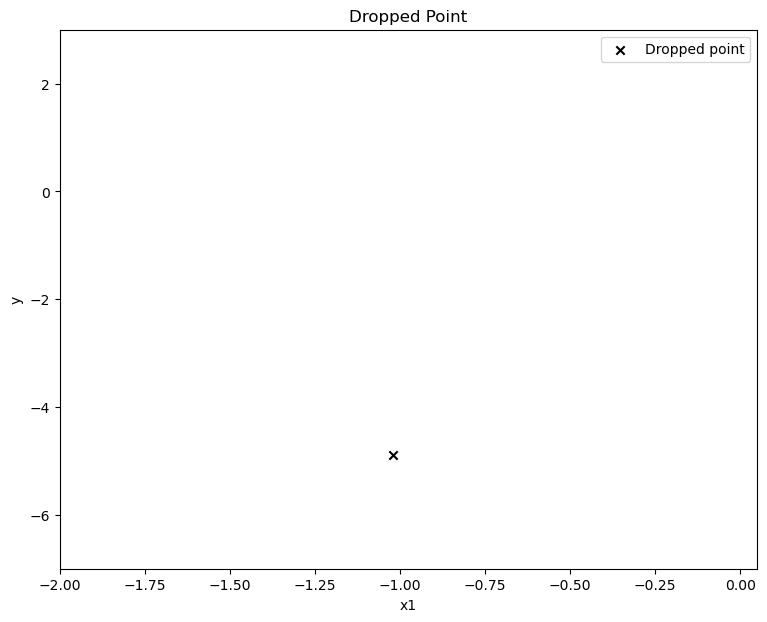

fitted beta1: 4.106163421093769
         x1        x2         y  residual  leverage  influence    newton
0 -1.097728  1.867558 -4.511361  0.061562  0.506268   0.028306  0.057330
1 -1.085410  0.313068 -4.572952 -0.062687  0.494998  -0.028604 -0.056642
2  0.000021 -2.552990 -1.532921 -1.501877  0.007789  -0.002759 -0.002780
3 -0.000023  0.864436 -1.711970 -1.654194  0.001864   0.003141  0.003147
4 -0.000046  2.269755  0.046135  0.114922  0.006648  -0.000395 -0.000397
5 -0.000006  0.045759 -0.958374 -0.907031  0.001016   0.000913  0.000914
6  0.000046  1.532779 -0.080812 -0.018130  0.003615   0.000048  0.000048
7  0.000012  0.154947 -0.703859 -0.651741  0.001047   0.000739  0.000740
8 -0.000063 -0.887786 -0.770784 -0.726461  0.001793  -0.000031 -0.000031
9  0.000005 -0.347912 -0.480845 -0.432605  0.001117   0.000251  0.000251
index 0 in create_plot 1


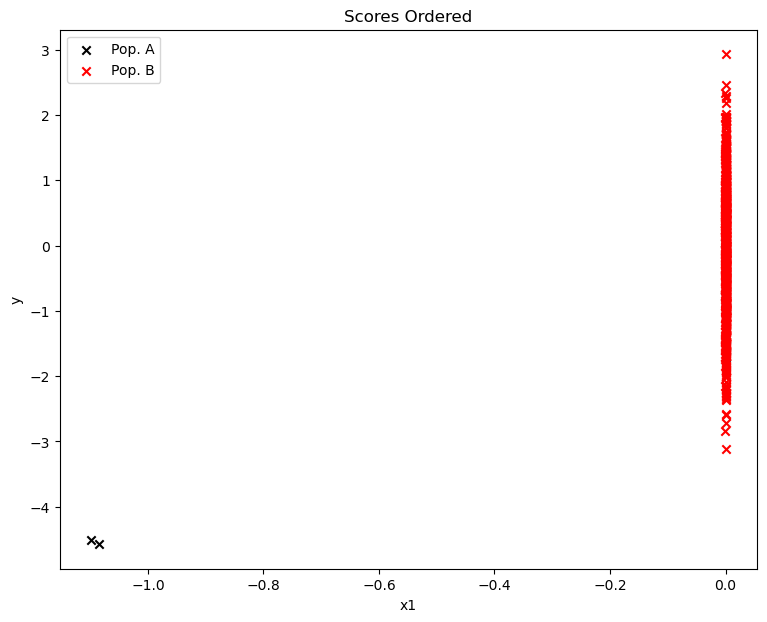

interation 8
index to remove 1


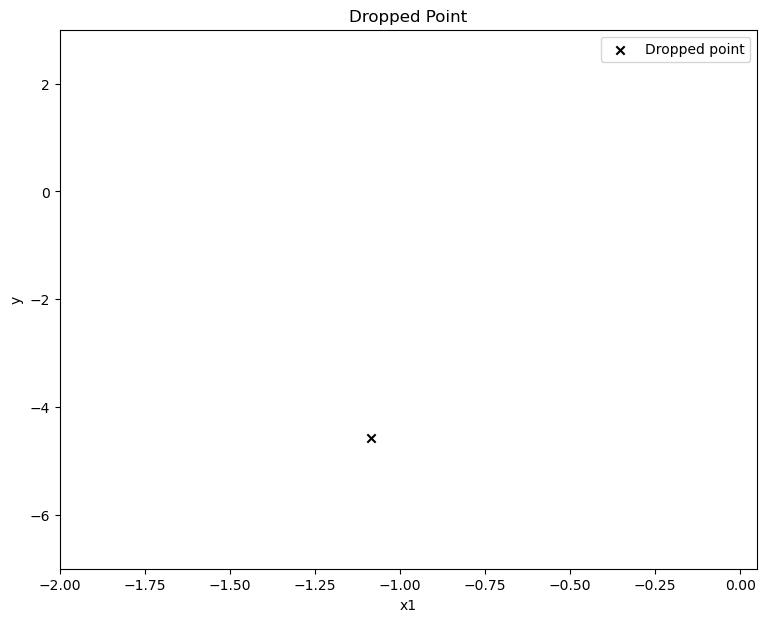

fitted beta1: 4.0495214295947575
         x1        x2         y  residual  leverage  influence      newton
0 -1.097728  1.867558 -4.511361 -0.000421  0.999999  -0.000384 -484.884612
1  0.000021 -2.552990 -1.532921 -1.502135  0.007797  -0.005582   -0.005626
2 -0.000023  0.864436 -1.711970 -1.654104  0.001865   0.004222    0.004230
3 -0.000046  2.269755  0.046135  0.115155  0.006655  -0.000590   -0.000594
4 -0.000006  0.045759 -0.958374 -0.907024  0.001016   0.000958    0.000959
5  0.000046  1.532779 -0.080812 -0.017968  0.003618   0.000069    0.000069
6  0.000012  0.154947 -0.703859 -0.651722  0.001047   0.000830    0.000830
7 -0.000063 -0.887786 -0.770784 -0.726553  0.001794  -0.000518   -0.000519
8  0.000005 -0.347912 -0.480845 -0.432638  0.001117   0.000147    0.000147
9  0.000038  1.230291  0.703586  0.764082  0.002707  -0.002505   -0.002512
index 0 in create_plot 255


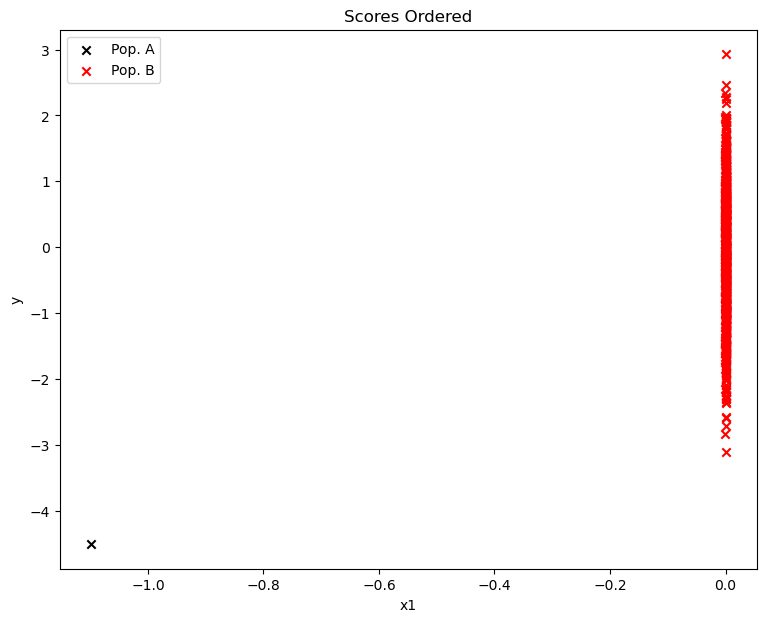

interation 9
index to remove 0


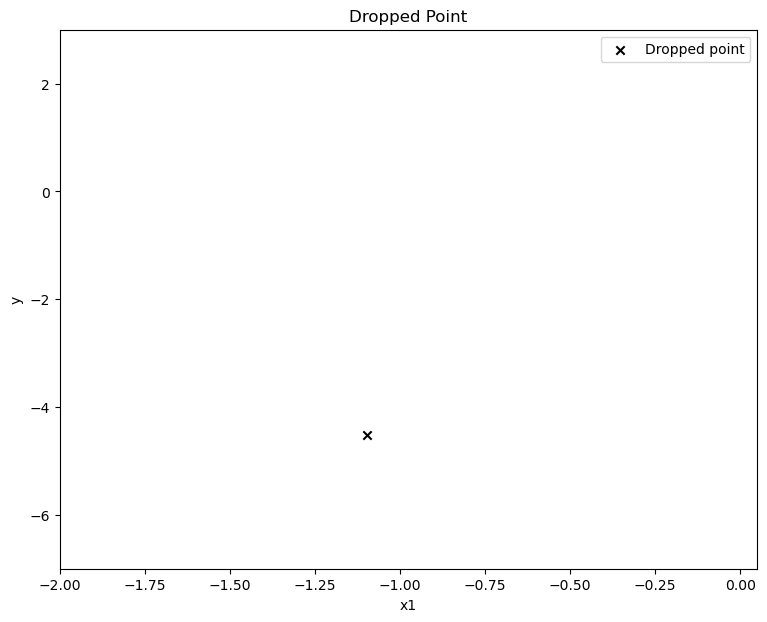

fitted beta1: -480.83508957276007
         x1        x2         y  residual  leverage  influence     newton
0  0.000021 -2.552990 -1.532921 -1.492503  0.008211  31.065786  31.322971
1 -0.000023  0.864436 -1.711970 -1.665080  0.002402 -39.496811 -39.591899
2 -0.000046  2.269755  0.046135  0.093585  0.008729   4.362497   4.400913
3 -0.000006  0.045759 -0.958374 -0.909681  0.001048  -5.222127  -5.227604
4  0.000046  1.532779 -0.080812  0.005122  0.005995  -0.255621  -0.257163
5  0.000012  0.154947 -0.703859 -0.645684  0.001209   8.426624   8.436828
6 -0.000063 -0.887786 -0.770784 -0.756929  0.005907 -49.695185 -49.990467
7  0.000005 -0.347912 -0.480845 -0.430118  0.001146   2.342436   2.345123
8  0.000038  1.230291  0.703586  0.783008  0.004303 -32.031567 -32.169999
9 -0.000010 -0.387327  0.929145  0.972579  0.001237   9.506101   9.517874
index 0 in create_plot 232


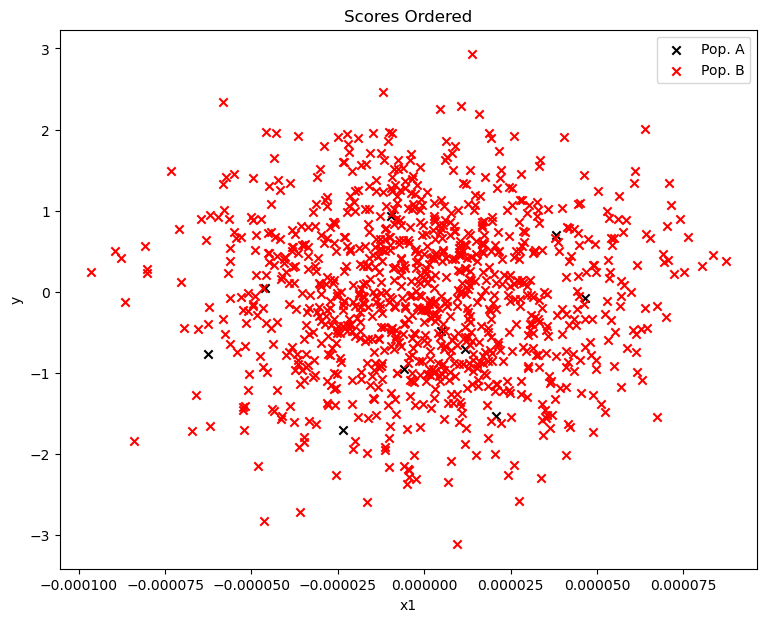

interation 10
index to remove 232


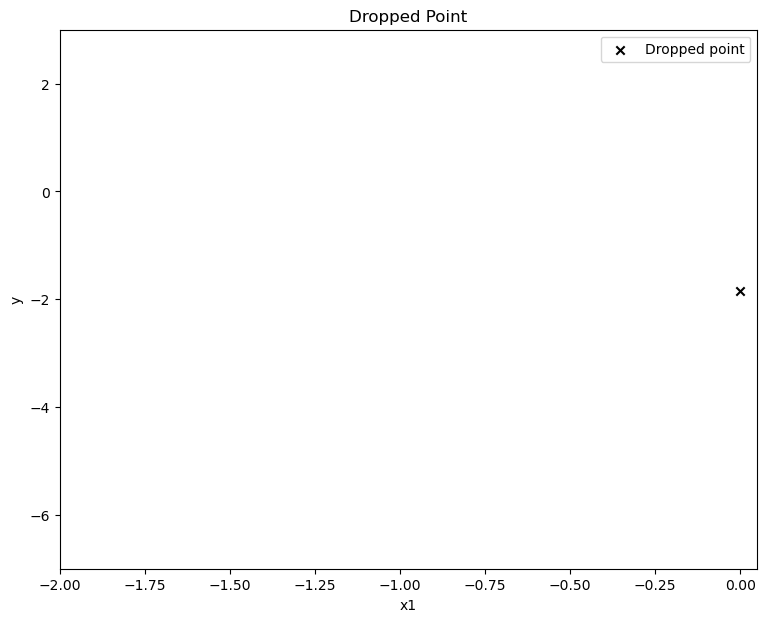

fitted beta1: -641.8777286565223
         x1        x2         y  residual  leverage  influence     newton
0  0.000021 -2.552990 -1.532921 -1.486729  0.008221  31.354044  31.613930
1 -0.000023  0.864436 -1.711970 -1.672168  0.002417 -40.228908 -40.326359
2 -0.000046  2.269755  0.046135  0.080503  0.008780   3.802807   3.836490
3 -0.000006  0.045759 -0.958374 -0.912564  0.001050  -5.363884  -5.369523
4  0.000046  1.532779 -0.080812  0.008171  0.005997  -0.408971  -0.411438
5  0.000012  0.154947 -0.703859 -0.645872  0.001209   8.423295   8.433494
6 -0.000063 -0.887786 -0.770784 -0.767374  0.005939 -50.762395 -51.065675
7  0.000005 -0.347912 -0.480845 -0.430590  0.001146   2.335348   2.338027
8  0.000038  1.230291  0.703586  0.785207  0.004305 -32.203643 -32.342865
9 -0.000010 -0.387327  0.929145  0.969838  0.001239   9.605779   9.617698
index 0 in create_plot 620


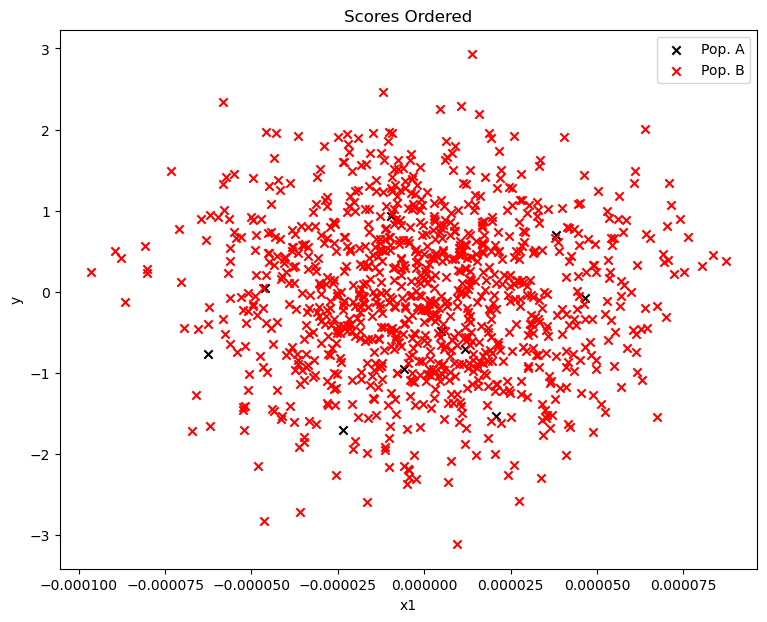

dropped order: 
 [1, 4, 3, 0, 3, 2, 1, 1, 1, 0, 232]
exact (greedy) beta estimates: 
 [4.9543525646285325, 4.803560471326711, 4.730686372045048, 4.641727336712975, 4.530019154813749, 4.412551481921444, 4.297914457994859, 4.106163421093769, 4.0495214295947575, -480.83508957276007, -641.8777286565223]


In [39]:
# reset greedy Newton loop.
x = orig_x
y = orig_y

### BEGIN GREEDY NEWTON LOOP (inds, x, y)
alpha = 0.01
ctr = 0
prev_beta = lr.beta[1] # initialize to the original beta estimate.
dropped_order = []
exact_changes_beta = []
beta_estimates_greedy = []
inds = original_inds
newton_inds = original_newton_inds

# while lr.beta[1] >= 0:
for _ in range(11):
    print(f'interation {ctr}')

    # 1. drop the datapoint with the most negative influence:
    index_to_remove_newton = newton_inds[0]
    print("index to remove", index_to_remove_newton)
    # print(f"x, y, leverage, residual, is, 1sN:\n {(orig_df['x1'][index_to_remove],orig_df['y'][index_to_remove], orig_df['leverage'][index_to_remove], orig_df['residual'][index_to_remove], orig_df['influence'][index_to_remove], orig_df['newton'][index_to_remove])}")
    
    ### (4/08) plot the dropped point.
    plot_dropped_point(x, y, index_to_remove_newton)
    
    dropped_order.append(index_to_remove_newton)

    new_x = np.concatenate((x[:index_to_remove_newton], x[index_to_remove_newton + 1:]))
    new_y = np.concatenate((y[:index_to_remove_newton], y[index_to_remove_newton + 1:]))

    x = new_x
    y = new_y

    # 2. calculate the exact perturbation (ie. refit the lr to get the change in the coefficient.)
    lr = LinearRegression(x=x.T, y=y)
    lr.fit()
    print(f'fitted beta1: {lr.beta[1]}')

    # 3. compute ranked influence scores for all datapoints remaining.
    if ctr == 11:
        print("last point standing:", scores[0])
    
    ### (4/01) CREATE PLOT.
    orig_df, inds, scores, newton_inds, newton_scores = create_orig_df(x, lr)
    create_plot(orig_df)

    # 4. record: the exact change in beta.
    beta_change = lr.beta[1] - prev_beta
    exact_changes_beta.append(beta_change)
    prev_beta = lr.beta[1]
    beta_estimates_greedy.append(lr.beta[1])

    # counter
    ctr += 1

#### Finish loop and print.
print("dropped order: \n", dropped_order[:15]) # (4/01) see if this is in the first 10 points. -> yep, it is.
print("exact (greedy) beta estimates: \n", beta_estimates_greedy[:15])
####